In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from math import sqrt, log, exp
import tensorflow as tf
import statistics
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print ("TensorFlow version found:", tf.__version__)


TensorFlow version found: 2.3.0


I used google colab to run this notebook and import my data. Thus my import methods are dependent on google colab and google drive. You can use any other import you wish to import the data but the easiest for me was to upload them in my google drive and load them in google colab.

Only run the above cell if you run the notebook on google colab. Else ignore it completely

In [ ]:
from google.colab import drive #run only if using google colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Below I build a datetime object which contains dates from March 7th to September 13th which is the final day we have data for the Datathon to predict next week. I use this datetime object as an index in my Pandas DataFrame later.

In [ ]:
import datetime
datetime_object_2= list()
today = datetime.date.today()
today = today.day
today_index = today-30
month = np.linspace(1,9,9)
day = np.linspace(1,31,31)
for i in month:
  for j in day:
    if(j==31 and i ==6 or j==31 and i==4 or j==31 and i==9 or j==29 and i==2):
      break
    datetime_object_2.append(datetime.date(2020,int(i),int(j)).strftime('%m/%d/%Y'))

datetime_object_hosp = datetime_object_2[90:-17]#index for hospitalizations
#here I set the datetime_index of my dataframe. If you want to insert new days you have to
#change the last index -17--> x (dates until end of september)
print(datetime_object_hosp)
datetime_object_deaths = datetime_object_2[65:-17] #index for deaths
print(datetime_object_deaths)


['04/01/2020', '04/02/2020', '04/03/2020', '04/04/2020', '04/05/2020', '04/06/2020', '04/07/2020', '04/08/2020', '04/09/2020', '04/10/2020', '04/11/2020', '04/12/2020', '04/13/2020', '04/14/2020', '04/15/2020', '04/16/2020', '04/17/2020', '04/18/2020', '04/19/2020', '04/20/2020', '04/21/2020', '04/22/2020', '04/23/2020', '04/24/2020', '04/25/2020', '04/26/2020', '04/27/2020', '04/28/2020', '04/29/2020', '04/30/2020', '05/01/2020', '05/02/2020', '05/03/2020', '05/04/2020', '05/05/2020', '05/06/2020', '05/07/2020', '05/08/2020', '05/09/2020', '05/10/2020', '05/11/2020', '05/12/2020', '05/13/2020', '05/14/2020', '05/15/2020', '05/16/2020', '05/17/2020', '05/18/2020', '05/19/2020', '05/20/2020', '05/21/2020', '05/22/2020', '05/23/2020', '05/24/2020', '05/25/2020', '05/26/2020', '05/27/2020', '05/28/2020', '05/29/2020', '05/30/2020', '05/31/2020', '06/01/2020', '06/02/2020', '06/03/2020', '06/04/2020', '06/05/2020', '06/06/2020', '06/07/2020', '06/08/2020', '06/09/2020', '06/10/2020', '06/1

Here I import the time series data for the covid deaths in 8 counties in Texas. Then I load them in a Pandas Dataframe.

In [ ]:
#data from John Hopkins repository, more accurate
import xlrd
#files can be imported by any available method, I import them from my drive using google colab
fatality_per_county_2 = pd.read_csv('/content/drive/My Drive/time_series_covid19_confirmed_HOU_09-13.csv',skiprows=0)
fatality_per_county = pd.read_csv('/content/drive/My Drive/time_series_covid19_confirmed_HOU_09-13.csv',skiprows=1)
Austin = fatality_per_county_2.iloc[0,58:]
Austin = pd.concat([Austin, pd.DataFrame([9.])],axis = 0)
fatality_per_county = fatality_per_county.T.iloc[58:]
fatality_per_county.columns = ["Brazoria","Chambers","Fort_Bend","Galveston","Harris","Liberty","Montgomery"]
test = pd.DataFrame([{'a': 155, 'b': 8., 'c':167.,'d':165.,'e':2420.,'f':46.,'g':145.}])
test.columns = ["Brazoria","Chambers","Fort_Bend","Galveston","Harris","Liberty","Montgomery"]
fatality_per_county = pd.concat([fatality_per_county,test])
fatality_per_county['Austin'] = Austin.values
fatality_per_county.index = datetime_object_deaths
print(fatality_per_county)


           Brazoria Chambers Fort_Bend  ... Liberty Montgomery Austin
03/07/2020        0        0         0  ...       0          0      0
03/08/2020        0        0         0  ...       0          0      0
03/09/2020        0        0         0  ...       0          0      0
03/10/2020        0        0         0  ...       0          0      0
03/11/2020        0        0         0  ...       0          0      0
...             ...      ...       ...  ...     ...        ...    ...
09/09/2020      148        6       255  ...      46        137      7
09/10/2020      148        6       255  ...      46        137      7
09/11/2020      154        8       263  ...      46        140      7
09/12/2020      155        8       266  ...      46        144      8
09/13/2020      155        8       167  ...      46        145      9

[191 rows x 8 columns]


Here I create a list which contains in every index an array which contains the deaths of the county. (list of lists)




In [ ]:
all = [fatality_per_county.iloc[:,4],fatality_per_county.iloc[:,5],fatality_per_county.iloc[:,6],fatality_per_county.iloc[:,0],fatality_per_county.iloc[:,1],fatality_per_county.iloc[:,2],fatality_per_county.iloc[:,3],fatality_per_county.iloc[:,7]]
all_title = ["Harris_deaths","Liberty_deaths","Montgomery_deaths","Brazoria_deaths","Chambers_deaths","Fort_Bend_deaths","Galveston_deaths","Austin_deaths"]
 


In [ ]:
all_dataframe = pd.concat(all,axis=1,names = all_title)
all_dataframe.columns = all_title
rolling_means = []
exp_means = []
for i in range(0,len(all_dataframe.columns)):
  rolling_mean = all_dataframe.iloc[:,i].rolling(window=7).mean()
  rolling_mean = rolling_mean.fillna(0)
  rolling_means.append(rolling_mean)
  exp_mean = all_dataframe.iloc[:,i].ewm(span=7, adjust=False).mean()
  exp_mean = exp_mean.fillna(0)
  exp_means.append(exp_mean)
print(all_dataframe)


           Harris_deaths Liberty_deaths  ... Galveston_deaths Austin_deaths
03/07/2020             0              0  ...                0             0
03/08/2020             0              0  ...                0             0
03/09/2020             0              0  ...                0             0
03/10/2020             0              0  ...                0             0
03/11/2020             0              0  ...                0             0
...                  ...            ...  ...              ...           ...
09/09/2020          2363             46  ...              165             7
09/10/2020          2363             46  ...              165             7
09/11/2020          2395             46  ...              165             7
09/12/2020          2414             46  ...              165             8
09/13/2020          2420             46  ...              165             9

[191 rows x 8 columns]


Here I visualize the data for each county and analyze its trend according to the 7 day exponential (green) and simple moving average (red)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


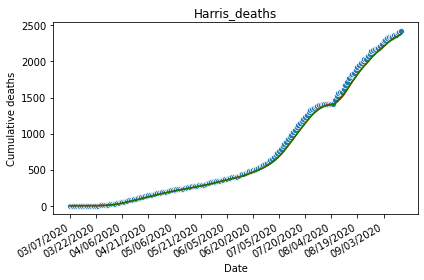

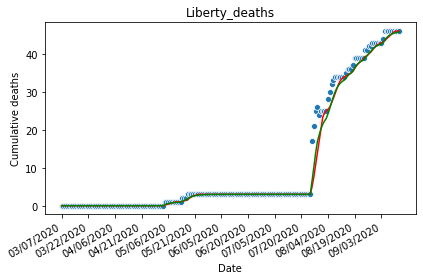

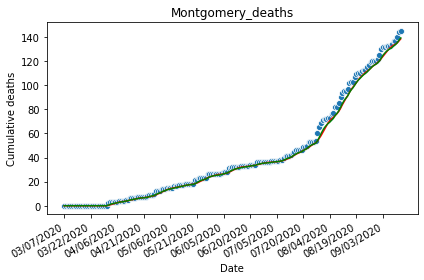

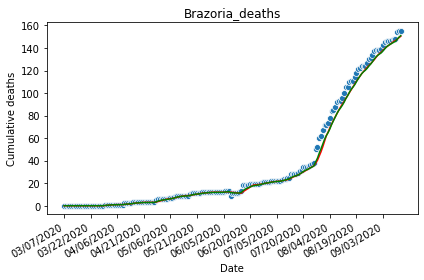

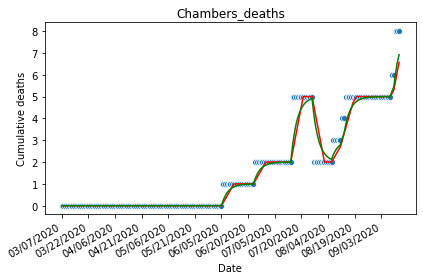

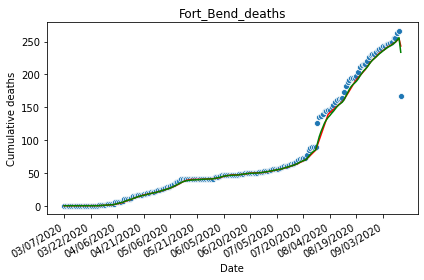

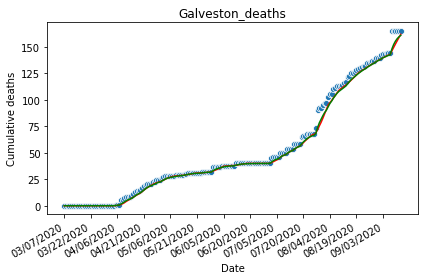

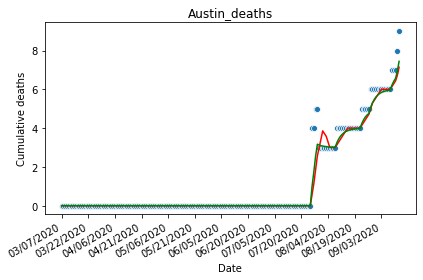

In [ ]:
import matplotlib.dates as mdates
import seaborn as sns
i = 0
for k in range(0,len(all)):
  fig, ax = plt.subplots()
  sns.scatterplot(list(all[k].index),list(all[k].values),ax=ax)
  plt.plot(all[k].index,rolling_means[i],color='r')
  plt.plot(all[k].index,exp_means[i],color='g')

# set the frequency for labelling the xaxis
  freq = int(15)
  plt.title(all_title[i])
  plt.ylabel("Cumulative deaths")
  plt.xlabel("Date")
# set the xlabels as the datetime data for the given labelling frequency,
# also use only the date for the label
  ax.set_xticklabels(all[k].iloc[::freq].index)
# set the xticks at the same frequency as the xlabels
  xtix = ax.get_xticks()
  ax.set_xticks(xtix[::freq])
# nicer label format for dates
  fig.autofmt_xdate()
  plt.tight_layout()
  plt.show()
  i = i +1


In [ ]:
fatality_per_county.isnull().values.any() #checking for nan values

False

Here I split my data to train_test for each county. I set a 97% train and 3% test which corresponds to a week ahead in order to evaluate my model. To make predictions for the week to come I train my model to 100% of the data.

The split_sequence function transforms my data to supervised learning where the X_data is a list that contains the features e.g. [45,45,46] with a specific window I set e.g. 3. The Y_data are the labels; the next day/timestep after X_data which is compared with the predicted value to calculate the error in training.

Depending on the data and on the county I choose different parameters value for the window e.g. [2,5,10,15]

In [ ]:
def split_sequence(sequence, n_steps): #n_steps = window
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
def split_train_test(data,tr,window):
	#train_deaths,test_deaths = [],[]
	train_size = int(len(data)*tr/100.0)
	#test_deaths.append(data[train_size-3:])
	#train_deaths.append(data[:train_size])
	temp_test_X = data[train_size-window-1:]#had -1, not good
	temp_train_X = data[:train_size]
	return np.array(temp_train_X),np.array(temp_test_X)
tr = 100 #was 97 now all training set!# percent.#change it when you change the data so the test set contains 9 value, in the split it will contain 7, exactly one week!
window = 10 #was 2
train_deaths=[]
test_deaths=[]
for i in all:
	 #scaler.fit(i.values.reshape(-1,1))
	 #temp_value = scaler.transform([i.values])
	 #print(temp_value)
	 tempp = i.values.reshape(len(i.values),)
	 temp_train,temp_test = split_train_test(tempp,tr,window)
	 #temp_train,temp_test = split_train_test(temp_value,tr,window)
	 train_deaths.append(temp_train)
	 test_deaths.append(temp_test)
X_train,Y_train = [],[]
X_test, Y_test = [],[]
for i in train_deaths:
	temp_X, temp_Y = split_sequence(i,window)
	X_train.append(temp_X)
	Y_train.append(temp_Y)
  
for i in test_deaths:
	temp_Xx, temp_Yy = split_sequence(i,window)
	X_test.append(temp_Xx)
	Y_test.append(temp_Yy)
print("X_test data for Libery county are ",X_test[1])# contains only one list with window 10 because I use 100% of training to predict next day
print("Y_test data for Liberty county are",Y_test[1])
#test must contain 9 values in order to predict 7!because we have train 2231, 2238
#X_test must contain 7!

	

#X_train_H, Y_train_H = split_sequence(train_Harris_deaths,window)

X_test data for Libery county are  [[43 44 46 46 46 46 46 46 46 46]]
Y_test data for Liberty county are [46.]


In [ ]:
look_ahead = 7 #how many days ahead the model will predict
value_Harris = X_test[0][0].reshape(1, window, 1) 
value_Liberty = X_test[1][0].reshape(1, window, 1)
value_Montgomery = X_test[2][0].reshape(1, window, 1)
value_Brazoria = X_test[3][0].reshape(1, window, 1)
value_Chambers = X_test[4][0].reshape(1, window, 1)
value_Fort_Bend = X_test[5][0].reshape(1, window, 1)
value_Galveston = X_test[6][0].reshape(1, window, 1)
value_Austin = X_test[7][0].reshape(1, window, 1)
initialvalue_Harris = tf.convert_to_tensor(list(value_Harris), dtype=tf.float32)# I transform the first day of the test data for each county to a tensor. Because otherwise the LSTM can't read it as input.
initialvalue_Liberty = tf.convert_to_tensor(list(value_Liberty),dtype=tf.float32)
initialvalue_Montgomery = tf.convert_to_tensor(list(value_Montgomery),dtype=tf.float32)
initialvalue_Brazoria = tf.convert_to_tensor(list(value_Brazoria), dtype=tf.float32)
initialvalue_Chambers = tf.convert_to_tensor(list(value_Chambers),dtype=tf.float32)
initialvalue_Fort_Bend = tf.convert_to_tensor(list(value_Fort_Bend),dtype=tf.float32)
initialvalue_Galveston = tf.convert_to_tensor(list(value_Galveston), dtype=tf.float32)
initialvalue_Austin = tf.convert_to_tensor(list(value_Austin),dtype=tf.float32)

Below starts the model preparation. Data processing complete

In [ ]:
"""def build_simple_univ_model(train_X,test_X,train_Y,test_Y,window):
  tf.random.set_seed(42)
  np.random.seed = 42
  verbose, epochs, batch_size = 0, 486, 16 #8.8 best, 386
  #n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[0], train_Y.shape[1]
  n_features = 1
  train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],n_features))
  print(train_X.shape)
  test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],n_features))
  train_X = tf.convert_to_tensor(list(train_X), dtype=tf.float32)
  test_X = tf.convert_to_tensor(list(test_X), dtype=tf.float32)
  model = Sequential() 
  model.add(LSTM(30 ,activation='relu',return_sequences=False,recurrent_activation ='sigmoid',input_shape=(window, n_features)))#30 best,window = 3 -->2 is better!
  #model.add(LeakyReLU(alpha=0.7))
  model.add(Dropout(0.2))
  #model.add(LSTM(60, activation='relu',return_sequences=False,recurrent_activation ='sigmoid',))#30 best
  #model.add(Dropout(0.2))
  #model.add(LSTM(50, activation='relu',recurrent_activation ='sigmoid'))#50,50
  #model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mae',optimizer='adam')
  from tensorflow.keras.callbacks import EarlyStopping 
  early_stopping = EarlyStopping(patience = 150, restore_best_weights = True,monitor='val_loss')#150 good
  history = model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, shuffle = False,validation_data = (test_X, test_Y),callbacks = [early_stopping])
  return model,history"""

#model, history = build_simple_univ_model(X_train[0][10:],X_test[0],np.array(Y_train[0][10:]),np.array(Y_test[0]),window)

"def build_simple_univ_model(train_X,test_X,train_Y,test_Y,window):\n  tf.random.set_seed(42)\n  np.random.seed = 42\n  verbose, epochs, batch_size = 0, 486, 16 #8.8 best, 386\n  #n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[0], train_Y.shape[1]\n  n_features = 1\n  train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],n_features))\n  print(train_X.shape)\n  test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],n_features))\n  train_X = tf.convert_to_tensor(list(train_X), dtype=tf.float32)\n  test_X = tf.convert_to_tensor(list(test_X), dtype=tf.float32)\n  model = Sequential() \n  model.add(LSTM(30 ,activation='relu',return_sequences=False,recurrent_activation ='sigmoid',input_shape=(window, n_features)))#30 best,window = 3 -->2 is better!\n  #model.add(LeakyReLU(alpha=0.7))\n  model.add(Dropout(0.2))\n  #model.add(LSTM(60, activation='relu',return_sequences=False,recurrent_activation ='sigmoid',))#30 best\n  #model.add(Dropout(0.2))\n  #model.add(LSTM

In [ ]:

def build_encoder_decoder(train_X,test_X,train_Y,test_Y,window):
  tf.random.set_seed(42)
  np.random.seed = 42
  temp_Y_train = np.array(train_Y)
  temp_Y_test = np.array(test_Y)
  n_steps_out = 1
  Y_train_encoder = temp_Y_train.reshape((temp_Y_train.shape[0],1,1))
  Y_test_encoder = temp_Y_test.reshape((temp_Y_test.shape[0],1,1))
  verbose, epochs, batch_size = 0, 686, 16 #8.8 best, 386
  #n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[0], train_Y.shape[1]
  n_features = 1
  train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],n_features))
  print(train_X.shape)
  test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],n_features))
  train_X = tf.convert_to_tensor(list(train_X), dtype=tf.float32)
  test_X = tf.convert_to_tensor(list(test_X), dtype=tf.float32)
  model = Sequential() 
  model.add(LSTM(100 ,activation='relu',recurrent_activation ='sigmoid',input_shape=(window, n_features)))#30 best,window = 3 -->2 is better!
  model.add(Dropout(0.2))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mae',optimizer='adam')
  plotted_model = plot_model(model, show_shapes=True, show_layer_names=True)
  from tensorflow.keras.callbacks import EarlyStopping 
  early_stopping = EarlyStopping(patience = 100, restore_best_weights = True,monitor='val_loss')#150 good
  history = model.fit(train_X, Y_train_encoder, epochs=epochs, batch_size=batch_size, shuffle = False,validation_data = (test_X, Y_test_encoder),callbacks = [early_stopping])
  return model,history, plotted_model #20: good

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
encoder_model,encoder_history, plotted_model = build_encoder_decoder(np.array(X_train[0][15:]),np.array(X_test[0]),np.array(Y_train[0][15:]),np.array(Y_test[0]),window)

(166, 10, 1)
Epoch 1/686
11/11 [==============================] - 0s 40ms/step - loss: 711.7532 - val_loss: 1757.1731
Epoch 2/686
11/11 [==============================] - 0s 18ms/step - loss: 494.8482 - val_loss: 975.4808
Epoch 3/686
11/11 [==============================] - 0s 18ms/step - loss: 196.9036 - val_loss: 195.2085
Epoch 4/686
11/11 [==============================] - 0s 17ms/step - loss: 202.1516 - val_loss: 118.6360
Epoch 5/686
11/11 [==============================] - 0s 18ms/step - loss: 243.6623 - val_loss: 1320.0708
Epoch 6/686
11/11 [==============================] - 0s 21ms/step - loss: 421.6610 - val_loss: 602.6265
Epoch 7/686
11/11 [==============================] - 0s 26ms/step - loss: 175.5490 - val_loss: 269.2483
Epoch 8/686
11/11 [==============================] - 0s 23ms/step - loss: 262.2914 - val_loss: 170.0376
Epoch 9/686
11/11 [==============================] - 0s 17ms/step - loss: 195.7341 - val_loss: 60.0654
Epoch 10/686
11/11 [==============================

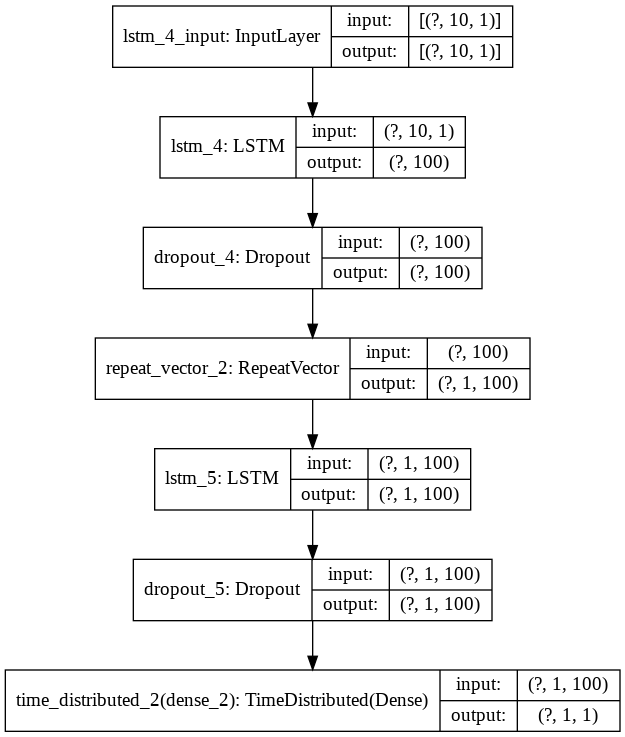

In [ ]:
plotted_model

In [ ]:
def build_conv_model(train_X,test_X,train_Y,test_Y,window):
	# prepare data
  tf.random.set_seed(42)
  np.random.seed = 42
  temp_Y_train = np.array(train_Y)
  temp_Y_test = np.array(test_Y)
  Y_train_conv = temp_Y_train.reshape((temp_Y_train.shape[0],1,1))
  Y_test_conv = temp_Y_test.reshape((temp_Y_test.shape[0],1,1))
  verbose, epochs, batch_size = 0, 686, 16 #was 16
  n_features = 1
  train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],n_features))
  test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],n_features))
  train_X = tf.convert_to_tensor(list(train_X), dtype=tf.float32)
  test_X = tf.convert_to_tensor(list(test_X), dtype=tf.float32)
  n_outputs=1
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(window,n_features)))#was 32, 32
  model.add(MaxPooling1D())#pool_size=2
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(50, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mae', optimizer='adam')
  from tensorflow.keras.callbacks import EarlyStopping 
  early_stopping = EarlyStopping(patience = 160, restore_best_weights = True,monitor='val_loss')#160 good
	# fit network
  history = model.fit(train_X, Y_train_conv, epochs=epochs, batch_size=batch_size, shuffle = False,validation_data = (test_X, Y_test_conv),callbacks = [early_stopping])
  plotted_model = plot_model(model, show_shapes=True, show_layer_names=True)
  return model,history,plotted_model

In [ ]:
conv_model,conv_history, plotted_model = build_conv_model(np.array(X_train[0][15:]),np.array(X_test[0]),np.array(Y_train[0][15:]),np.array(Y_test[0]),window)

Epoch 1/686
11/11 [==============================] - 0s 24ms/step - loss: 556.9108 - val_loss: 1036.7673
Epoch 2/686
11/11 [==============================] - 0s 6ms/step - loss: 122.9622 - val_loss: 391.0803
Epoch 3/686
11/11 [==============================] - 0s 5ms/step - loss: 43.0262 - val_loss: 102.9148
Epoch 4/686
11/11 [==============================] - 0s 5ms/step - loss: 120.7628 - val_loss: 35.8118
Epoch 5/686
11/11 [==============================] - 0s 5ms/step - loss: 119.1222 - val_loss: 210.0127
Epoch 6/686
11/11 [==============================] - 0s 5ms/step - loss: 45.1645 - val_loss: 72.5364
Epoch 7/686
11/11 [==============================] - 0s 5ms/step - loss: 39.5949 - val_loss: 6.3623
Epoch 8/686
11/11 [==============================] - 0s 5ms/step - loss: 144.3714 - val_loss: 57.6316
Epoch 9/686
11/11 [==============================] - 0s 5ms/step - loss: 104.5469 - val_loss: 188.7876
Epoch 10/686
11/11 [==============================] - 0s 5ms/step - loss: 39.74

In [ ]:
#here you load your model because when the kernel disconnects you lose the weights! No need to run this cell, just for reference. I used it to load good trained weights
"""
from tensorflow.keras.models import model_from_json
model_json = conv_model_Galveston.to_json()
with open("conv_model_Galveston_hosp.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
conv_model_Galveston.save_weights("conv_model_Galveston_hosp.h5")
print("Saved model to disk")"""
 

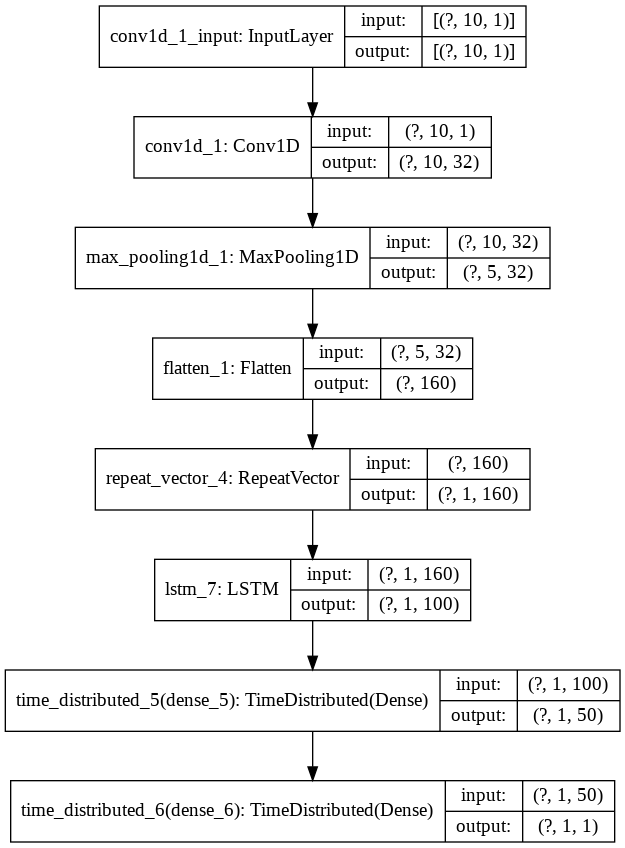

In [ ]:
plotted_model

In [ ]:
"""from tensorflow.keras.models import model_from_json
json_file = open('encoder_model_Harris_hosp.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("encoder_model_Harris_hosp.h5")# for Harris model.

#loaded_model.predict(value)"""

Here I build a simple function that is used to make a 7-day forecast on our data. The LSTM model predicts one single value, so I append this predicted value to the last item of the test window and remove the first value of the window and repeat that 6 times.

In [ ]:
def predictionOnPredictionLSTM(initialValue, nOfPredictions,model):
  
  # Start the predictions.
  inputs = initialValue
  # Create an empty array.
  predictions = []

  # Loop over the test set data and make prediction using 
  for i in range(nOfPredictions) :
    v = model.predict(inputs,verbose=0) # [5,6,7] 6.5 --> [6,6.5] -> [6.5,7]
    predictions.append(v)
    # Create the next input.
    inputs = np.roll(inputs, -1) # [7,6,5] --> [7,6,6.5]
    inputs[0][-1] = v 
  return np.array(predictions)



In [ ]:
"""from sklearn.metrics import mean_squared_log_error
#Harris_predictions_model_1
#print(len(train_deaths[0]),len(test_deaths[0]))
predictions = predictions.reshape(len(predictions))
print(predictions)
print(test_deaths[0][window:])
print(mean_absolute_error(predictions,test_deaths[0][window:]))
print(mean_squared_log_error(predictions,test_deaths[0][window:]))"""
#best 2.269217mean_absolute_error
#1.8697e-06 mean_squared_log_error

[2281.6726 2277.6128 2271.6475 2266.4023 2260.9163 2255.5408 2250.1475]
[2295.0 2298.0 2299.0 2300.0 2300.0 2300.0 2300.0]
32.580043247767854
0.00023238006195369865


In [ ]:
predictions_encoder =  predictionOnPredictionLSTM(initialvalue_Harris,look_ahead,encoder_model)#encoder_model  predictions
predictions_conv_Harris = predictionOnPredictionLSTM(initialvalue_Harris,look_ahead,conv_model)

In [ ]:
#Harris_prediction_model_1

"""predictions_encoder = predictions_encoder.reshape(len(predictions_encoder))
print(predictions_encoder)
print(test_deaths[0][window:])
#print(mean_absolute_error(predictions_encoder,test_deaths[0][window:]))#for evaluating when train is 97% and test 3%
#print(mean_squared_log_error(predictions_encoder,test_deaths[0][window:]))
#[2315.637  2337.772  2349.0872 2360.1472 2379.7527 2400.502  2416.9834] for window =10 and 15:"""

[2410.8052 2220.5317 2369.7473 2408.9995 2525.3313 2383.6375 2831.5552]
[2420.0]
[1812 1829 1838 1875 1920 1953 1978 2011 2028 2030 2072 2106 2140 2153
 2177 2188 2192 2208 2247 2281 2300 2327 2335 2335 2342 2363 2363 2395
 2414 2420.0]


This is my first prediction for week_2 (the first printed row). I trained another convolutional model with different window parameter and took the average between the two as my last prediction (ensemble). This can be seen far below in the 3rd from last cell of this notebook.

Note that the values are not exactly the same (diffence of +-2) because everytime I run the model I get slightly differen weights due to randomness when training the model.

In [ ]:
#Harris_prediction_model_3
from sklearn.metrics import mean_squared_log_error
predictions_conv_Harris = predictions_conv_Harris.reshape(len(predictions_conv_Harris))
print(predictions_conv_Harris)
print(test_deaths[0][window:])

#print(mean_absolute_error(predictions_conv_Harris,test_deaths[0][window:]))
#print(mean_squared_log_error(predictions_conv_Harris,test_deaths[0][window:]))
print(train_deaths[0][-30:])
#[2323.4692 2341.0374 2356.7148 2375.0168 2390.6448 2407.288  2421.0159] for window = 15
#[2420.7942 2437.5059 2449.8225 2465.4849 2479.7554 2495.0405 2510.6333] for window = 10 

[2420.7942 2437.5059 2449.8225 2465.4849 2479.7554 2495.0405 2510.6333]
[2420.0]
[1812 1829 1838 1875 1920 1953 1978 2011 2028 2030 2072 2106 2140 2153
 2177 2188 2192 2208 2247 2281 2300 2327 2335 2335 2342 2363 2363 2395
 2414 2420.0]


To train the second model for Liberty I use the [1] index of the X_train list of lists and ignore the first 20 days because they contain meaningless values (0).

In [ ]:
#Liberty model

conv_model_Liberty,conv_history_Liberty = build_conv_model(np.array(X_train[1][20:]),np.array(X_test[1]),np.array(Y_train[1][20:]),np.array(Y_test[1]),window)
encoder_model_Liberty,encoder_history_Liberty = build_encoder_decoder(np.array(X_train[1][20:]),np.array(X_test[1]),np.array(Y_train[1][20:]),np.array(Y_test[1]),window)
#build_encoder_decoder


Epoch 1/686
11/11 [==============================] - 0s 35ms/step - loss: 9.6285 - val_loss: 23.6094
Epoch 2/686
11/11 [==============================] - 0s 8ms/step - loss: 2.6358 - val_loss: 4.3669
Epoch 3/686
11/11 [==============================] - 0s 8ms/step - loss: 1.8493 - val_loss: 2.4949
Epoch 4/686
11/11 [==============================] - 0s 9ms/step - loss: 1.4312 - val_loss: 0.5154
Epoch 5/686
11/11 [==============================] - 0s 8ms/step - loss: 3.4838 - val_loss: 4.2757
Epoch 6/686
11/11 [==============================] - 0s 8ms/step - loss: 2.3746 - val_loss: 3.7545
Epoch 7/686
11/11 [==============================] - 0s 8ms/step - loss: 3.2720 - val_loss: 5.3903
Epoch 8/686
11/11 [==============================] - 0s 9ms/step - loss: 1.4840 - val_loss: 3.2578
Epoch 9/686
11/11 [==============================] - 0s 9ms/step - loss: 2.1250 - val_loss: 0.1009
Epoch 10/686
11/11 [==============================] - 0s 8ms/step - loss: 3.9953 - val_loss: 6.6210
Epoch 1

I tranform my predictions to integers because the predictions are almost stable regarding last week and thus it doesn't make sense to try to predict precision.

In [ ]:

predictions_conv_Liberty = predictionOnPredictionLSTM(initialvalue_Liberty,look_ahead,conv_model_Liberty) #here write either the encoder or conv model, keep the best
predictions_conv_Liberty = predictions_conv_Liberty.reshape(len(predictions_conv_Liberty))
predictions_final = []
for i in predictions_conv_Liberty[0:4]:
  predictions_final.append(round(i))
print("Predictions for first week are:",predictions_final,round(46.92746) , round(47.16774) , 48 )
print("Predictions for second week are:",predictions_final,round(46.92746) , round(47.16774) , 47.5) # first and second week data didn't change so predictions almost stay the same!
#print(mean_absolute_error(predictions_conv_Liberty,test_deaths[1][window:]))
#print(mean_squared_log_error(predictions_conv_Liberty,test_deaths[1][window:]))
#[46.5739, 46.68, 46.77, 46. 82, 46.92746  47.16774  47.554] prediction from other model. Keep last 3 values and make them integer or keep them between 0.5 and 1.
#Last 3 days are from different prediction conv model that 

Predictions for first week are: [46.0, 46.0, 46.0, 46.0] 47 47 48
Predictions for second week are: [46.0, 46.0, 46.0, 46.0] 47 47 47.5


In [ ]:
#Montgomery model

conv_model_Montgomery,conv_history_Montgomery = build_conv_model(np.array(X_train[2][30:]),np.array(X_test[2]),np.array(Y_train[2][30:]),np.array(Y_test[2]),window)
encoder_model_Montgomery,conv_history_Montgomery = build_encoder_decoder(np.array(X_train[2][30:]),np.array(X_test[2]),np.array(Y_train[2][30:]),np.array(Y_test[2]),window)
#build_encoder_decoder, #150: best


(145, 10, 1)
(145, 10, 1)
Epoch 1/686
10/10 [==============================] - 0s 26ms/step - loss: 34.1874 - val_loss: 62.7980
Epoch 2/686
10/10 [==============================] - 0s 6ms/step - loss: 7.8906 - val_loss: 18.5745
Epoch 3/686
10/10 [==============================] - 0s 5ms/step - loss: 3.6651 - val_loss: 4.4225
Epoch 4/686
10/10 [==============================] - 0s 5ms/step - loss: 6.3217 - val_loss: 8.9339
Epoch 5/686
10/10 [==============================] - 0s 5ms/step - loss: 6.2041 - val_loss: 4.8845
Epoch 6/686
10/10 [==============================] - 0s 6ms/step - loss: 4.4893 - val_loss: 7.9688
Epoch 7/686
10/10 [==============================] - 0s 6ms/step - loss: 4.8084 - val_loss: 1.8299
Epoch 8/686
10/10 [==============================] - 0s 6ms/step - loss: 5.8157 - val_loss: 9.5364
Epoch 9/686
10/10 [==============================] - 0s 7ms/step - loss: 5.3547 - val_loss: 3.3485
Epoch 10/686
10/10 [==============================] - 0s 7ms/step - loss: 4.191

Predictions for second week can be seen below. The predictions start from the second value (145.1) because 144.24391 is an invalid prediction (< of last day).
That's why we have 8 values and just select last 7. 

Again in the first printed row are the predictions and in the others the test data and the train data just for reference.

Predictions for the first week cannot be seen here because the model parameters have been changed but the method is the same (just train until train[0:-7]).

In [ ]:

predictions_conv_Mont = predictionOnPredictionLSTM(initialvalue_Montgomery,look_ahead+1,encoder_model_Montgomery)
predictions_conv_Mont = predictions_conv_Mont.reshape(len(predictions_conv_Mont))
print(predictions_conv_Mont)
print(test_deaths[2][window:])
print(train_deaths[2][150:])
print(test_deaths[2])
#print(mean_absolute_error(predictions_conv_Mont,test_deaths[2][window:]))
#print(mean_squared_log_error(predictions_conv_Mont,test_deaths[2][window:]))#7.74 MAE best
#prediction = [145.10944 146.31076 147.6109  149.19351 151.1802  153.07767 154.71606]

[144.24391 145.10944 146.31076 147.6109  149.19351 151.1802  153.07767
 154.71606]
[133 134 137 137 140 144 145]
[73 76 77 82 82 85 90 94 95 95 97 102 103 103 107 109 110 110 112 113 113
 115 117 119 120 120 120 122 125 130 132 132 133 133 133]
[120 120 120 122 125 130 132 132 133 133 133 134 137 137 140 144 145]


In [ ]:
conv_model_Brazoria,conv_history_Brazoria = build_conv_model(np.array(X_train[3][50:]),np.array(X_test[3]),np.array(Y_train[3][50:]),np.array(Y_test[3]),window)#140 best
encoder_model_Brazoria,encoder_history_Brazoria = build_encoder_decoder(np.array(X_train[3][50:]),np.array(X_test[3]),np.array(Y_train[3][50:]),np.array(Y_test[3]),window)

Epoch 1/686
9/9 [==============================] - 0s 38ms/step - loss: 38.0379 - val_loss: 81.8316
Epoch 2/686
9/9 [==============================] - 0s 9ms/step - loss: 10.6553 - val_loss: 18.0734
Epoch 3/686
9/9 [==============================] - 0s 8ms/step - loss: 6.4953 - val_loss: 8.9747
Epoch 4/686
9/9 [==============================] - 0s 8ms/step - loss: 9.4832 - val_loss: 12.8793
Epoch 5/686
9/9 [==============================] - 0s 8ms/step - loss: 4.7588 - val_loss: 12.6079
Epoch 6/686
9/9 [==============================] - 0s 10ms/step - loss: 4.0701 - val_loss: 3.6160
Epoch 7/686
9/9 [==============================] - 0s 9ms/step - loss: 3.7763 - val_loss: 2.8995
Epoch 8/686
9/9 [==============================] - 0s 8ms/step - loss: 8.1620 - val_loss: 8.2610
Epoch 9/686
9/9 [==============================] - 0s 9ms/step - loss: 4.7465 - val_loss: 12.6632
Epoch 10/686
9/9 [==============================] - 0s 8ms/step - loss: 4.4748 - val_loss: 4.9263
Epoch 11/686
9/9 [==

The predictions are very close to what I submitted. Every time I run the model predictions may change a bit. Similarly due to randomness weights are slightly different. 

In [ ]:
predictions_encoder_Brazoria = predictionOnPredictionLSTM(initialvalue_Brazoria,look_ahead,encoder_model_Brazoria)
predictions_encoder_Brazoria = predictions_encoder_Brazoria.reshape(len(predictions_encoder_Brazoria))
print("Predictions for second week are:",predictions_encoder_Brazoria)# 120: is good for window = 7!, encoder
#print(test_deaths[3][window:])#loaded weights and it's fine
#print(train_deaths[3][-20:])
print("Test data are:",test_deaths[3])
#trained it with window = 7 for first week, 10 for second
#print(mean_absolute_error(predictions_conv_Brazoria,test_deaths[3][window:]))
#print(mean_squared_log_error(predictions_conv_Brazoria,test_deaths[3][window:]))
#[153.62431 155.44801 156.077   157.16106 158.01569 158.86296 159.82701]

Predictions for second week are: [155.16408 156.25136 157.60457 158.62617 159.08263 160.21729 161.73271]
Test data are: [143 145 146 146 146 147 148 148 154 155 155.0]


In [ ]:
conv_model_Chambers,conv_history_Chambers = build_conv_model(np.array(X_train[4][20:]),np.array(X_test[4]),np.array(Y_train[4][20:]),np.array(Y_test[4]),window)#100 best
encoder_model_Chambers,encoder_history_Chambers = build_encoder_decoder(np.array(X_train[4][20:]),np.array(X_test[4]),np.array(Y_train[4][20:]),np.array(Y_test[4]),window)#120

Epoch 1/686
11/11 [==============================] - 0s 31ms/step - loss: 1.9249 - val_loss: 6.8353
Epoch 2/686
11/11 [==============================] - 0s 9ms/step - loss: 1.2722 - val_loss: 3.5331
Epoch 3/686
11/11 [==============================] - 0s 8ms/step - loss: 0.7445 - val_loss: 0.0983
Epoch 4/686
11/11 [==============================] - 0s 9ms/step - loss: 0.6495 - val_loss: 1.4631
Epoch 5/686
11/11 [==============================] - 0s 8ms/step - loss: 0.7711 - val_loss: 0.4470
Epoch 6/686
11/11 [==============================] - 0s 9ms/step - loss: 0.5479 - val_loss: 1.1150
Epoch 7/686
11/11 [==============================] - 0s 8ms/step - loss: 0.7390 - val_loss: 0.4824
Epoch 8/686
11/11 [==============================] - 0s 8ms/step - loss: 0.5240 - val_loss: 1.5999
Epoch 9/686
11/11 [==============================] - 0s 8ms/step - loss: 0.5278 - val_loss: 0.9533
Epoch 10/686
11/11 [==============================] - 0s 8ms/step - loss: 0.5660 - val_loss: 0.0470
Epoch 11

First week's data are reproduced if you run the model for 
X_train[0:-7] ,Y_train[0:-7].


Again predictions are almost identical to submission file.

In [ ]:
predictions_Chambers = predictionOnPredictionLSTM(initialvalue_Chambers,look_ahead,conv_model_Chambers)#+difference_Brazoria[-1]#,encoder_model_Brazoria)#0.5=bias due to stationarity
predictions_Chambers = predictions_Chambers.reshape(len(predictions_Chambers))
print("Second week prediction is",predictions_Chambers)
#print(mean_absolute_error(predictions_Chambers,test_deaths[4][window:]))
#print(mean_squared_log_error(predictions_Chambers,test_deaths[4][window:]))
#[8.0012865  8.324205   8.627693   8.991761   9.381204   9.81089,10.276717 ]

Second week prediction is [ 8.000809  8.311843  8.614     8.892143  9.214599  9.637418 10.08719 ]


In [ ]:
conv_model_Fort,conv_history_Fort = build_conv_model(np.array(X_train[5][20:]),np.array(X_test[5]),np.array(Y_train[5][20:]),np.array(Y_test[5]),window)#100 best
encoder_model_Fort,encoder_history_Fort = build_encoder_decoder(np.array(X_train[5][20:]),np.array(X_test[5]),np.array(Y_train[5][20:]),np.array(Y_test[5]),window)#120

(161, 10, 1)
(161, 10, 1)
Epoch 1/686
11/11 [==============================] - 0s 24ms/step - loss: 57.8640 - val_loss: 102.6817
Epoch 2/686
11/11 [==============================] - 0s 7ms/step - loss: 11.1132 - val_loss: 6.6718
Epoch 3/686
11/11 [==============================] - 0s 5ms/step - loss: 11.1545 - val_loss: 20.2940
Epoch 4/686
11/11 [==============================] - 0s 6ms/step - loss: 22.3229 - val_loss: 42.4408
Epoch 5/686
11/11 [==============================] - 0s 5ms/step - loss: 11.7842 - val_loss: 16.9062
Epoch 6/686
11/11 [==============================] - 0s 6ms/step - loss: 8.2354 - val_loss: 5.4453
Epoch 7/686
11/11 [==============================] - 0s 6ms/step - loss: 10.1094 - val_loss: 14.1972
Epoch 8/686
11/11 [==============================] - 0s 7ms/step - loss: 20.3898 - val_loss: 37.7426
Epoch 9/686
11/11 [==============================] - 0s 5ms/step - loss: 11.0648 - val_loss: 15.1844
Epoch 10/686
11/11 [==============================] - 0s 5ms/step 

This cell

In [ ]:
predictions_Fort = predictionOnPredictionLSTM(initialvalue_Fort_Bend,look_ahead,encoder_model_Fort)
predictions_Fort = predictions_Fort.reshape(len(predictions_Fort))
print(predictions_Fort)
print(test_deaths[5][window:])
print(train_deaths[5][160:]) 
#print(mean_absolute_error(predictions_Fort,test_deaths[5][window:]))
#print(mean_squared_log_error(predictions_Fort,test_deaths[5][window:]))
#[246.77965 247.47505 248.43849 248.72125 249.26256 249.62228 250.13065] 1st week
#[268.51748 272.66992 275.28616 278.30945 280.80664 283.64792 286.3341 ] 
#[267.47186 271.59134 274.0211  277.9578  281.1139  284.804   288.48596]
#[267.67062 270.18558 272.92804 275.56403 278.72568 281.89233 285.80176]2nd week

[267.67062 270.18558 272.92804 275.56403 278.72568 281.89233 285.80176]
[267.0]
[189 192 194 194 194 198 204 211 214 216 216 220 226 230 231 231 234 237
 239 240 243 244 247 247 248 249 255 255 263 266 267.0]


In [ ]:
conv_model_Austin,conv_history_Austin = build_conv_model(np.array(X_train[7][-30:]),np.array(X_test[7]),np.array(Y_train[7][-30:]),np.array(Y_test[7]),window)#100 best
encoder_model_Austin,encoder_history_Austin = build_encoder_decoder(np.array(X_train[7][-30:]),np.array(X_test[7]),np.array(Y_train[7][-30:]),np.array(Y_test[7]),window)#120

Epoch 1/686
2/2 [==============================] - 0s 146ms/step - loss: 5.5274 - val_loss: 8.5842
Epoch 2/686
2/2 [==============================] - 0s 14ms/step - loss: 5.1724 - val_loss: 8.0987
Epoch 3/686
2/2 [==============================] - 0s 14ms/step - loss: 4.8171 - val_loss: 7.5358
Epoch 4/686
2/2 [==============================] - 0s 14ms/step - loss: 4.4044 - val_loss: 6.8531
Epoch 5/686
2/2 [==============================] - 0s 15ms/step - loss: 3.9050 - val_loss: 5.9854
Epoch 6/686
2/2 [==============================] - 0s 14ms/step - loss: 3.2765 - val_loss: 4.8957
Epoch 7/686
2/2 [==============================] - 0s 14ms/step - loss: 2.4957 - val_loss: 3.5514
Epoch 8/686
2/2 [==============================] - 0s 14ms/step - loss: 1.5321 - val_loss: 1.9055
Epoch 9/686
2/2 [==============================] - 0s 14ms/step - loss: 0.7734 - val_loss: 0.2321
Epoch 10/686
2/2 [==============================] - 0s 12ms/step - loss: 0.9086 - val_loss: 0.7906
Epoch 11/686
2/2 [

In [ ]:
predictions_Austin = predictionOnPredictionLSTM(initialvalue_Austin,look_ahead,conv_model_Austin)#+3#+difference_Brazoria[-1]#,encoder_model_Brazoria)#0.5=bias due to stationarity
predictions_Austin = predictions_Austin.reshape(len(predictions_Austin))
#print(predictions_Austin)# 20: use window = 2 here!!!
#print(test_deaths[7][window:])#loaded weights and it's fine
#print(train_deaths[7][160:]) #make predictions integers, 0.00037
#print(mean_absolute_error(predictions_Austin,test_deaths[7][window:]))
#print(mean_squared_log_error(predictions_Austin,test_deaths[7][window:]))

[ 9.147432   9.953366  10.628498  11.7541895 12.876578  14.358517
 16.112059 ]


In [ ]:
conv_model_Galveston,conv_history_Galveston = build_conv_model(np.array(X_train[6][30:]),np.array(X_test[6]),np.array(Y_train[6][30:]),np.array(Y_test[6]),window)#100 best
encoder_model_Galveston,encoder_history_Galveston = build_encoder_decoder(np.array(X_train[6][30:]),np.array(X_test[6]),np.array(Y_train[6][30:]),np.array(Y_test[6]),window)#120

Epoch 1/686
10/10 [==============================] - 0s 34ms/step - loss: 44.8519 - val_loss: 71.4986
Epoch 2/686
10/10 [==============================] - 0s 8ms/step - loss: 11.7163 - val_loss: 21.5248
Epoch 3/686
10/10 [==============================] - 0s 9ms/step - loss: 5.3202 - val_loss: 1.0956
Epoch 4/686
10/10 [==============================] - 0s 9ms/step - loss: 6.5035 - val_loss: 4.0017
Epoch 5/686
10/10 [==============================] - 0s 8ms/step - loss: 6.1885 - val_loss: 1.7984
Epoch 6/686
10/10 [==============================] - 0s 8ms/step - loss: 9.3862 - val_loss: 13.2034
Epoch 7/686
10/10 [==============================] - 0s 8ms/step - loss: 7.1014 - val_loss: 7.4647
Epoch 8/686
10/10 [==============================] - 0s 8ms/step - loss: 4.9615 - val_loss: 4.7630
Epoch 9/686
10/10 [==============================] - 0s 9ms/step - loss: 5.3408 - val_loss: 0.0706
Epoch 10/686
10/10 [==============================] - 0s 8ms/step - loss: 7.0591 - val_loss: 8.8709
Epo

In [ ]:
predictions_Galveston = predictionOnPredictionLSTM(initialvalue_Galveston,look_ahead,conv_model_Galveston)#+difference_Brazoria[-1]#,encoder_model_Brazoria)#0.5=bias due to stationarity
predictions_Galveston = predictions_Galveston.reshape(len(predictions_Galveston))
print("Prediction for second week is:",predictions_Galveston)# 20: use window = 2!!!
#print(test_deaths[6][window:])#loaded weights and it's fine
#print(train_deaths[6][160:]) #make predictions integers, 0.00037
#print(mean_absolute_error(predictions_Galveston,test_deaths[6][window:]))#Check galveston again, maybe implement diff/bias method!
#print(mean_squared_log_error(predictions_Galveston,test_deaths[6][window:]))
#164.7857  167.35925 169.55275 171.98668 174.38051 176.82349 179.33896
#[165.00296 165.09131 169.01877 170.19328 172.41519 174.02005 174.8002 ] prediction.. 2nd week

Prediction for second week is: [165.0039  165.12003 169.60738 170.824   173.59613 175.36617 176.14713]


Hospitalization starts here

I import from my drive the 8 files containing county hospitalization data.

In [ ]:
#insert data
import xlrd
#files can be imported by any available method, I import them from my drive using google colab
harris_hosp = pd.read_excel('/content/drive/My Drive/Hospitalizationdata/harris_hosp_0913.xlsx',usecols=[2,3])
liberty_hosp=pd.read_excel('/content/drive/My Drive/Hospitalizationdata/liberty_hosp_0913.xlsx',usecols=[2,3])
montgomery_hosp = pd.read_excel('/content/drive/My Drive/Hospitalizationdata/montgomery_hosp_0913.xlsx',usecols=[2,3])
brazoria_hosp  = pd.read_excel('/content/drive/My Drive/Hospitalizationdata/brazoria_hosp_0913.xlsx',usecols=[2,3])
chambers_hosp  = pd.read_excel('/content/drive/My Drive/Hospitalizationdata/chambers_hosp_0913.xlsx',usecols=[2,3])
fortbend_hosp  = pd.read_excel('/content/drive/My Drive/Hospitalizationdata/fortbend_hosp_0913.xlsx',usecols=[2,3])
galveston_hosp  = pd.read_excel('/content/drive/My Drive/Hospitalizationdata/galveston_hosp_0913.xlsx',usecols=[2,3])
austin_hosp  = pd.read_excel('/content/drive/My Drive/Hospitalizationdata/austin_hosp_0913.xlsx',usecols=[2,3])

#harris_hosp_0904.xlsx
all_names = ["harris_hosp_0913","liberty_hosp_0913","montgomery_hosp_0913","brazoria_hosp_0913","chambers_hosp_0913","fortbend_hosp_09_13","galveston_hosp_09_13","austin_hosp_09_13"]
#all = [harris_hosp_0904,liberty_hosp_0904,montgomery_hosp_0904,brazoria_hosp_0904,chambers_hosp_0904,fortbend_hosp_09_04,galveston_hosp_09_04,austin_hosp_09_04]


In [ ]:
harris_hosp['Total'] = harris_hosp['CovidBed']+harris_hosp['ICUCovidBed']
harris_hosp.index = datetime_object_hosp
liberty_hosp['Total'] = liberty_hosp['CovidBed']+liberty_hosp['ICUCovidBed']
liberty_hosp.index = datetime_object_hosp
montgomery_hosp['Total'] = montgomery_hosp['CovidBed']+montgomery_hosp['ICUCovidBed']
montgomery_hosp.index = datetime_object_hosp
brazoria_hosp['Total'] = brazoria_hosp['CovidBed']+brazoria_hosp['ICUCovidBed']
brazoria_hosp.index = datetime_object_hosp
chambers_hosp['Total'] = chambers_hosp['CovidBed']+chambers_hosp['ICUCovidBed']
chambers_hosp.index = datetime_object_hosp
fortbend_hosp['Total'] = fortbend_hosp['CovidBed']+fortbend_hosp['ICUCovidBed']
fortbend_hosp.index = datetime_object_hosp
galveston_hosp['Total'] = galveston_hosp['CovidBed']+galveston_hosp['ICUCovidBed']
galveston_hosp.index = datetime_object_hosp
austin_hosp['Total'] = austin_hosp['CovidBed']+austin_hosp['ICUCovidBed']
austin_hosp.index = datetime_object_hosp
all_hosp = [harris_hosp['Total'],liberty_hosp['Total'],montgomery_hosp['Total'],brazoria_hosp['Total'],chambers_hosp['Total'],fortbend_hosp['Total'],galveston_hosp['Total'],austin_hosp['Total']]

In [ ]:
print(harris_hosp.iloc[-10:])

            CovidBed  ICUCovidBed  Total
09/04/2020       526          259    785
09/05/2020       517          250    767
09/06/2020       415          245    660
09/07/2020       438          227    665
09/08/2020       449          222    671
09/09/2020       482          223    705
09/10/2020       495          217    712
09/11/2020       472          234    706
09/12/2020       461          206    667
09/13/2020       412          195    607


In [ ]:
all_dataframe_hosp = pd.concat(all_hosp, axis=1,names = all_names)
all_dataframe_hosp.columns = all_names
print(all_dataframe_hosp)
rolling_means_hosp = []
exp_means_hosp = []
for i in range(0,len(all_dataframe_hosp.columns)):
  rolling_mean_hosp = all_dataframe_hosp.iloc[:,i].rolling(window=7).mean()
  rolling_mean_hosp = rolling_mean_hosp.fillna(0)
  rolling_means_hosp.append(rolling_mean_hosp)
  exp_mean = all_dataframe_hosp.iloc[:,i].ewm(span=7, adjust=False).mean()
  exp_mean = exp_mean.fillna(0)
  exp_means_hosp.append(exp_mean)

            harris_hosp_0913  ...  austin_hosp_09_13
04/01/2020               248  ...                  0
04/02/2020               235  ...                  0
04/03/2020               545  ...                  0
04/04/2020               616  ...                  0
04/05/2020               584  ...                  0
...                      ...  ...                ...
09/09/2020               705  ...                  0
09/10/2020               712  ...                  0
09/11/2020               706  ...                  0
09/12/2020               667  ...                  0
09/13/2020               607  ...                  0

[166 rows x 8 columns]


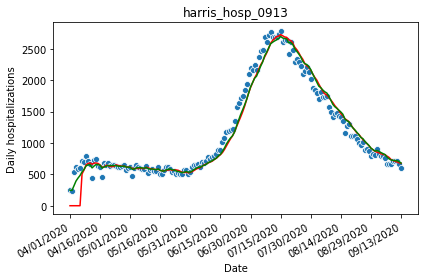

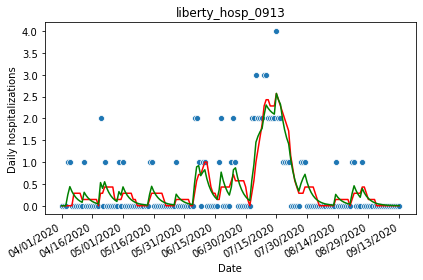

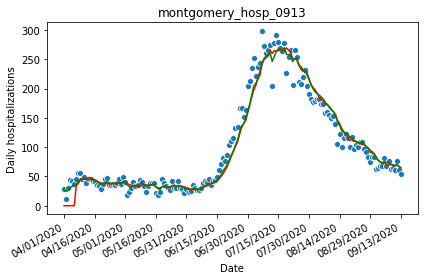

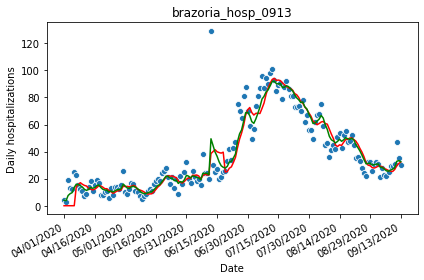

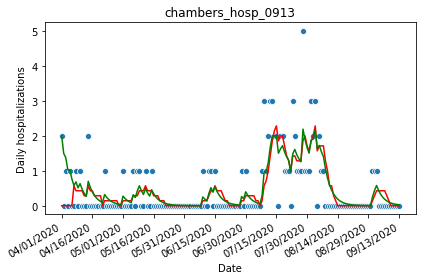

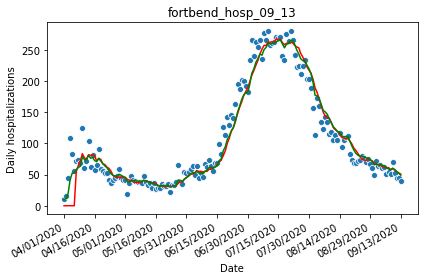

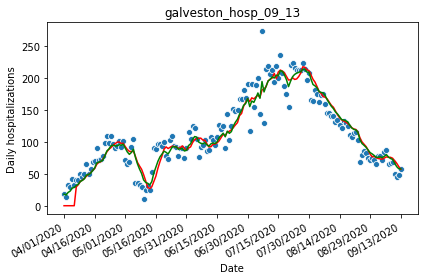

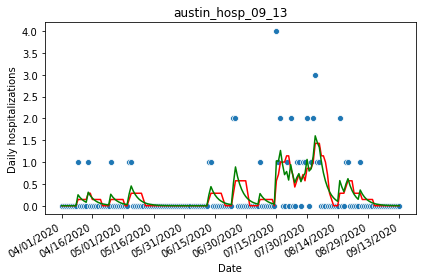

In [ ]:
import matplotlib.dates as mdates
import seaborn as sns
i = 0
for k in range(0,len(all_hosp)):
  fig, ax = plt.subplots()
  sns.scatterplot(list(all_hosp[k].index),list(all_hosp[k].values),ax=ax)
  plt.plot(all_hosp[k].index,rolling_means_hosp[i],color='r')
  plt.plot(all_hosp[k].index,exp_means_hosp[i],color='g')

# set the frequency for labelling the xaxis
  freq = int(15)
  plt.title(all_names[i])
  plt.ylabel("Daily hospitalizations")
  plt.xlabel("Date")
# set the xlabels as the datetime data for the given labelling frequency,
# also use only the date for the label
  ax.set_xticklabels(all_hosp[k].iloc[::freq].index)
# set the xticks at the same frequency as the xlabels
  xtix = ax.get_xticks()
  ax.set_xticks(xtix[::freq])
# nicer label format for dates
  fig.autofmt_xdate()
  plt.tight_layout()
  i = i +1
  plt.show()
 


In [ ]:
tr = 100#was 96.5 # percent.#change it when you change the data so the test set contains 9 value, in the split it will contain 7, exactly one week!
window_2 = 5 #was 3,10 best
train_deaths_hosp=[]
test_deaths_hosp= []

for i in all_hosp:
	 tempp = i.values.reshape(len(i.values),)
	 temp_train,temp_test = split_train_test(tempp,tr,window_2)
	 #temp_train,temp_test = split_train_test(temp_value,tr,window)
	 train_deaths_hosp.append(temp_train)
	 test_deaths_hosp.append(temp_test)
X_train_hosp,Y_train_hosp = [],[]
X_test_hosp, Y_test_hosp = [],[]
for i in train_deaths_hosp:
	temp_X, temp_Y = split_sequence(i,window_2)
	X_train_hosp.append(temp_X)
	Y_train_hosp.append(temp_Y)
  
for i in test_deaths_hosp:
	temp_Xx, temp_Yy = split_sequence(i,window_2)
	X_test_hosp.append(temp_Xx)
	Y_test_hosp.append(temp_Yy)
 

#print(X_train_hosp[0],X_test_hosp[0])
#print(len(X_test_hosp[0]))
#X_test must be 7!

In [ ]:
X_train_hosp_expma = []
Y_train_hosp_expma = []
for i in exp_means_hosp:
  temp_X, temp_Y = split_sequence(i.values,window_2)
  #temp_X = np.array(temp_X)
  #temp_Y = np.array(temp_Y)
  X_train_hosp_expma.append(temp_X)
  Y_train_hosp_expma.append(temp_Y)


In [ ]:
look_ahead = 7
value_Harris_hosp = X_test_hosp[0][0].reshape(1, window_2, 1)
value_Liberty_hosp = X_test_hosp[1][0].reshape(1, window_2, 1)
value_Montgomery_hosp = X_test_hosp[2][0].reshape(1, window_2, 1)
value_Brazoria_hosp = X_test_hosp[3][0].reshape(1, window_2, 1)
value_Chambers_hosp = X_test_hosp[4][0].reshape(1, window_2, 1)
value_Fort_Bend_hosp = X_test_hosp[5][0].reshape(1, window_2, 1)
value_Galveston_hosp = X_test_hosp[6][0].reshape(1, window_2, 1)
value_Austin_hosp = X_test_hosp[7][0].reshape(1, window_2, 1)
initialvalue_Harris_hosp = tf.convert_to_tensor(list(value_Harris_hosp), dtype=tf.float32)
initialvalue_Liberty_hosp = tf.convert_to_tensor(list(value_Liberty_hosp),dtype=tf.float32)
initialvalue_Montgomery_hosp = tf.convert_to_tensor(list(value_Montgomery_hosp),dtype=tf.float32)
initialvalue_Brazoria_hosp = tf.convert_to_tensor(list(value_Brazoria_hosp), dtype=tf.float32)
initialvalue_Chambers_hosp = tf.convert_to_tensor(list(value_Chambers_hosp),dtype=tf.float32)
initialvalue_Fort_Bend_hosp = tf.convert_to_tensor(list(value_Fort_Bend_hosp),dtype=tf.float32)
initialvalue_Galveston_hosp = tf.convert_to_tensor(list(value_Galveston_hosp), dtype=tf.float32)
initialvalue_Austin_hosp = tf.convert_to_tensor(list(value_Austin_hosp),dtype=tf.float32)

In [ ]:

def build_encoder_decoder_h(train_X,test_X,train_Y,test_Y,window):
  tf.random.set_seed(42)
  np.random.seed = 42
  temp_Y_train = np.array(train_Y)
  temp_Y_test = np.array(test_Y)
  n_steps_out = 1
  Y_train_encoder = temp_Y_train.reshape((temp_Y_train.shape[0],1,1))
  Y_test_encoder = temp_Y_test.reshape((temp_Y_test.shape[0],1,1))
  verbose, epochs, batch_size = 0, 686, 16 #8.8 best, 386
  n_features = 1
  train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],n_features))
  print(train_X.shape)
  test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],n_features))
  train_X = tf.convert_to_tensor(list(train_X), dtype=tf.float32)
  test_X = tf.convert_to_tensor(list(test_X), dtype=tf.float32)
  model = Sequential() 
  model.add(LSTM(100 ,activation='relu',recurrent_activation ='sigmoid',input_shape=(window, n_features)))
  model.add(Dropout(0.2))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mae',optimizer='adam')
  from tensorflow.keras.callbacks import EarlyStopping 
  early_stopping = EarlyStopping(patience = 160, restore_best_weights = True,monitor='val_loss')#150 good
  history = model.fit(train_X, Y_train_encoder, epochs=epochs, batch_size=batch_size, shuffle = False,validation_data = (test_X, Y_test_encoder),callbacks = [early_stopping])
  return model,history 

In [ ]:
def build_conv_model_h(train_X,test_X,train_Y,test_Y,window):
	# prepare data
  tf.random.set_seed(42)
  np.random.seed = 42
  temp_Y_train = np.array(train_Y)
  temp_Y_test = np.array(test_Y)
  Y_train_conv = temp_Y_train.reshape((temp_Y_train.shape[0],1,1))
  Y_test_conv = temp_Y_test.reshape((temp_Y_test.shape[0],1,1))
  verbose, epochs, batch_size = 0, 686, 16 #was 16
  n_features = 1
  train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],n_features))
  test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],n_features))
  train_X = tf.convert_to_tensor(list(train_X), dtype=tf.float32)
  test_X = tf.convert_to_tensor(list(test_X), dtype=tf.float32)
  n_outputs=1
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=window_2-1, activation='relu', input_shape=(window,n_features)))#kernel_size=2 for window = 3
  model.add(MaxPooling1D())#pool_size=2))
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(50, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mae', optimizer='adam')
  from tensorflow.keras.callbacks import EarlyStopping 
  early_stopping = EarlyStopping(patience = 160, restore_best_weights = True,monitor='val_loss')#150 good
	# fit network
  history = model.fit(train_X, Y_train_conv, epochs=epochs, batch_size=batch_size, shuffle = False,validation_data = (test_X, Y_test_conv),callbacks = [early_stopping])
  return model,history

In [ ]:
encoder_model_Harris,encoder_history_Harris = build_encoder_decoder_h(np.array(X_train_hosp_expma[0][70:]),np.array(X_test_hosp[0]),np.array(Y_train_hosp_expma[0][70:]),np.array(Y_test_hosp[0]),window_2)
conv_model_Harris,conv_history_Harris = build_conv_model_h(np.array(X_train_hosp_expma[0][70:]),np.array(X_test_hosp[0]),np.array(Y_train_hosp_expma[0][70:]),np.array(Y_test_hosp[0]),window_2)

(93, 3, 1)
Epoch 1/686
6/6 [==============================] - 0s 75ms/step - loss: 1579.4316 - val_loss: 575.7552
Epoch 2/686
6/6 [==============================] - 0s 17ms/step - loss: 1531.1794 - val_loss: 536.6180
Epoch 3/686
6/6 [==============================] - 0s 17ms/step - loss: 1445.8508 - val_loss: 491.6672
Epoch 4/686
6/6 [==============================] - 0s 15ms/step - loss: 1353.4413 - val_loss: 432.1930
Epoch 5/686
6/6 [==============================] - 0s 17ms/step - loss: 1184.0901 - val_loss: 345.3907
Epoch 6/686
6/6 [==============================] - 0s 17ms/step - loss: 904.2183 - val_loss: 168.9793
Epoch 7/686
6/6 [==============================] - 0s 18ms/step - loss: 509.3490 - val_loss: 64.4606
Epoch 8/686
6/6 [==============================] - 0s 16ms/step - loss: 359.4446 - val_loss: 153.2858
Epoch 9/686
6/6 [==============================] - 0s 14ms/step - loss: 284.8084 - val_loss: 107.3446
Epoch 10/686
6/6 [==============================] - 0s 15ms/step - 

In [ ]:

predictions_hosp_Harris = predictionOnPredictionLSTM(initialvalue_Harris_hosp,look_ahead,conv_model_Harris)
predictions_hosp_Harris = predictions_hosp_Harris.reshape(len(predictions_hosp_Harris))
print(predictions_hosp_Harris)
print(train_deaths_hosp[0][-20:])
print(test_deaths_hosp[0])
#print(mean_absolute_error(predictions_hosp_Harris,test_deaths_hosp[0][window_2:]))
#print(mean_squared_log_error(predictions_hosp_Harris,test_deaths_hosp[0][window_2:]))
#[721.77356 712.42664 673.3252  635.06647 610.22815 581.2126  551.75415] 1st week
#[ 636.788   626.026   618.71826 623.69507 614.1832  600.37854 585.93115] 
#[648.8522  630.1971  616.67267 613.0903  600.22144 589.7575  580.5178 ], 
#[636.788 ,  626.026 ,  618.71826, 623.69507 ,600.22144,589.7575 , 580.5178] #final 2nd week

[658.02124 636.5361  613.6591  599.67267 579.2134  561.867   546.1658 ]
[1010  889  898  865  789  821  805  904  826  789  785  767  660  665
  671  705  712  706  667  607]
[712 706 667 607]


In [ ]:
encoder_model_Liberty,encoder_history_Liberty = build_encoder_decoder_h(np.array(X_train_hosp_expma[1][:]),np.array(X_test_hosp[1]),np.array(Y_train_hosp_expma[1][:]),np.array(Y_test_hosp[1]),window_2)
conv_model_Liberty,conv_history_Liberty = build_conv_model_h(np.array(X_train_hosp_expma[1][:]),np.array(X_test_hosp[1]),np.array(Y_train_hosp_expma[1][:]),np.array(Y_test_hosp[1]),window_2)

(129, 30, 1)
Epoch 1/686
9/9 [==============================] - 1s 76ms/step - loss: 0.4750 - val_loss: 0.0350
Epoch 2/686
9/9 [==============================] - 0s 42ms/step - loss: 0.3990 - val_loss: 0.1022
Epoch 3/686
9/9 [==============================] - 0s 41ms/step - loss: 0.5163 - val_loss: 0.0937
Epoch 4/686
9/9 [==============================] - 0s 44ms/step - loss: 0.3642 - val_loss: 0.0679
Epoch 5/686
9/9 [==============================] - 0s 45ms/step - loss: 0.3836 - val_loss: 0.0693
Epoch 6/686
9/9 [==============================] - 0s 45ms/step - loss: 0.3774 - val_loss: 0.0783
Epoch 7/686
9/9 [==============================] - 0s 45ms/step - loss: 0.3693 - val_loss: 0.0897
Epoch 8/686
9/9 [==============================] - 0s 44ms/step - loss: 0.3558 - val_loss: 0.1016
Epoch 9/686
9/9 [==============================] - 0s 42ms/step - loss: 0.3357 - val_loss: 0.1099
Epoch 10/686
9/9 [==============================] - 0s 43ms/step - loss: 0.3260 - val_loss: 0.1114
Epoch 

Predictions for both first and second week for Liberty hospitalization county

In [ ]:

predictions_hosp_Liberty = predictionOnPredictionLSTM(initialvalue_Liberty_hosp,look_ahead,encoder_model_Liberty)
predictions_hosp_Liberty = predictions_hosp_Liberty.reshape(len(predictions_hosp_Liberty))
print(predictions_hosp_Liberty)
print(test_deaths_hosp[1][window:])
print(train_deaths_hosp[1][-20:])
#print(train_deaths_hosp[0][150:])
#conv model best 0.019 window = 3
#print(mean_absolute_error(predictions_hosp_Liberty,test_deaths_hosp[1][window_2:]))
#print(mean_squared_log_error(predictions_hosp_Liberty,test_deaths_hosp[1][window_2:]))

[0.00070713 0.00133595 0.00234038 0.00352938 0.0047998  0.00600645
 0.0071775 ]
[0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
encoder_model_Montgomery,encoder_history_Montgomery = build_encoder_decoder_h(np.array(X_train_hosp[2][30:]),np.array(X_test_hosp[2]),np.array(Y_train_hosp[2][30:]),np.array(Y_test_hosp[2]),window_2)
conv_model_Montgomery,conv_history_Montgomery = build_conv_model_h(np.array(X_train_hosp[2][30:]),np.array(X_test_hosp[2]),np.array(Y_train_hosp[2][30:]),np.array(Y_test_hosp[2]),window_2)

(131, 5, 1)
Epoch 1/686
9/9 [==============================] - 1s 57ms/step - loss: 112.2556 - val_loss: 45.5113
Epoch 2/686
9/9 [==============================] - 0s 20ms/step - loss: 80.2254 - val_loss: 4.1668
Epoch 3/686
9/9 [==============================] - 0s 19ms/step - loss: 40.6427 - val_loss: 4.3827
Epoch 4/686
9/9 [==============================] - 0s 19ms/step - loss: 36.3764 - val_loss: 3.3421
Epoch 5/686
9/9 [==============================] - 0s 19ms/step - loss: 27.3717 - val_loss: 8.8929
Epoch 6/686
9/9 [==============================] - 0s 23ms/step - loss: 24.8235 - val_loss: 9.1138
Epoch 7/686
9/9 [==============================] - 0s 21ms/step - loss: 24.0210 - val_loss: 7.1093
Epoch 8/686
9/9 [==============================] - 0s 22ms/step - loss: 23.7526 - val_loss: 10.6381
Epoch 9/686
9/9 [==============================] - 0s 19ms/step - loss: 22.0608 - val_loss: 6.5235
Epoch 10/686
9/9 [==============================] - 0s 19ms/step - loss: 21.8331 - val_loss: 6

In [ ]:

predictions_hosp_Montgomery = predictionOnPredictionLSTM(initialvalue_Montgomery_hosp,look_ahead,conv_model_Montgomery)
predictions_hosp_Montgomery = predictions_hosp_Montgomery.reshape(len(predictions_hosp_Montgomery))
print("Predictions for second week is",predictions_hosp_Montgomery)
#print(test_deaths_hosp[2][window:])
#print(mean_absolute_error(predictions_hosp_Montgomery,test_deaths_hosp[2][window_2:]))
#print(mean_squared_log_error(predictions_hosp_Montgomery,test_deaths_hosp[2][window_2:]))
#[66.97783 68.46707 67.36516 66.63943 64.96595 66.45057 62.30796]1st week
#[59.950928 55.185307 52.84615  50.147797 50.81942  50.982178 49.417046] 2nd week
#[59.92499  54.64683  53.495754 49.320377 49.55309  45.013844 43.299374]


Predictions for second week is [61.739635 60.86918  60.03604  57.474285 53.708492 52.73098  50.78721 ]
[61 77 61 54]
[108  96  92  84  74  84  83  62  65  68  68  82  67  77  63  64  61  77
  61  54]


In [ ]:
encoder_model_Brazoria,encoder_history_Brazoria = build_encoder_decoder_h(np.array(X_train_hosp[3][30:]),np.array(X_test_hosp[3]),np.array(Y_train_hosp[3][30:]),np.array(Y_test_hosp[3]),window_2)
conv_model_Brazoria,conv_history_Brazoria = build_conv_model_h(np.array(X_train_hosp[3][30:]),np.array(X_test_hosp[3]),np.array(Y_train_hosp[3][30:]),np.array(Y_test_hosp[3]),window_2)

(131, 5, 1)
Epoch 1/686
9/9 [==============================] - 1s 56ms/step - loss: 42.2378 - val_loss: 24.6246
Epoch 2/686
9/9 [==============================] - 0s 19ms/step - loss: 23.1174 - val_loss: 8.6619
Epoch 3/686
9/9 [==============================] - 0s 21ms/step - loss: 29.8052 - val_loss: 0.9414
Epoch 4/686
9/9 [==============================] - 0s 18ms/step - loss: 16.2252 - val_loss: 6.8244
Epoch 5/686
9/9 [==============================] - 0s 20ms/step - loss: 13.0362 - val_loss: 2.9533
Epoch 6/686
9/9 [==============================] - 0s 20ms/step - loss: 14.0778 - val_loss: 1.8643
Epoch 7/686
9/9 [==============================] - 0s 23ms/step - loss: 11.2014 - val_loss: 0.2853
Epoch 8/686
9/9 [==============================] - 0s 21ms/step - loss: 11.5836 - val_loss: 4.2244
Epoch 9/686
9/9 [==============================] - 0s 20ms/step - loss: 11.9115 - val_loss: 0.5136
Epoch 10/686
9/9 [==============================] - 0s 19ms/step - loss: 11.6318 - val_loss: 2.2

In [ ]:

predictions_hosp_Brazoria = predictionOnPredictionLSTM(initialvalue_Brazoria_hosp,look_ahead,conv_model_Brazoria)
predictions_hosp_Brazoria = predictions_hosp_Brazoria.reshape(len(predictions_hosp_Brazoria))
#print(predictions_hosp_Brazoria)
#print(test_deaths_hosp[3][window:])
#print(train_deaths_hosp[3][-20:]) # put smaller window (e.g.4)
#conv with 50: best (2.79) window = 2, or 2.75 with 20:
#print(mean_absolute_error(predictions_hosp_Brazoria,test_deaths_hosp[3][window_2:]))
#print(mean_squared_log_error(predictions_hosp_Brazoria,test_deaths_hosp[3][window_2:]))
#[21.998697 19.482649 18.963905 19.884718 19.096195 17.927074 17.467596]
print("Prediction of first week is :",[22.021269 ,20.658545, 19.740294 ,19.015366, 18.47681 , 18.032284 ,17.736917] )#1st week
#[26.206995 26.850891 27.842733 28.7694   28.969711 28.849827 28.510479]
#[29.990364 37.636543 46.50364  31.085344 27.497902 27.020609 21.223059] 
#[29.993618 36.97773  36.9332   33.374626 36.494392 39.635876 38.17873 ]
print("Prediction of second week is :",[29.993618 ,36.97773 , 36.9332 ,  33.374626,27.497902 ,27.497902,27.020609 ,21.223059] )#2nd week

Prediction of first week is : [22.021269, 20.658545, 19.740294, 19.015366, 18.47681, 18.032284, 17.736917]
Prediction of second week is : [29.993618, 36.97773, 36.9332, 33.374626, 27.497902, 27.497902, 27.020609, 21.223059]


In [ ]:
encoder_model_Chambers,encoder_history_Chambers = build_encoder_decoder_h(np.array(X_train_hosp_expma[4][:]),np.array(X_test_hosp[4]),np.array(Y_train_hosp_expma[4][:]),np.array(Y_test_hosp[4]),window_2)
conv_model_Chambers,conv_history_Chambers = build_conv_model_h(np.array(X_train_hosp_expma[4][:]),np.array(X_test_hosp[4]),np.array(Y_train_hosp_expma[4][:]),np.array(Y_test_hosp[4]),window_2)

(149, 10, 1)
Epoch 1/686
10/10 [==============================] - 0s 43ms/step - loss: 0.4544 - val_loss: 0.0507
Epoch 2/686
10/10 [==============================] - 0s 19ms/step - loss: 0.3831 - val_loss: 0.1435
Epoch 3/686
10/10 [==============================] - 0s 16ms/step - loss: 0.2692 - val_loss: 0.2504
Epoch 4/686
10/10 [==============================] - 0s 16ms/step - loss: 0.2701 - val_loss: 0.2462
Epoch 5/686
10/10 [==============================] - 0s 18ms/step - loss: 0.2653 - val_loss: 0.2282
Epoch 6/686
10/10 [==============================] - 0s 17ms/step - loss: 0.2659 - val_loss: 0.2027
Epoch 7/686
10/10 [==============================] - 0s 19ms/step - loss: 0.2455 - val_loss: 0.2099
Epoch 8/686
10/10 [==============================] - 0s 17ms/step - loss: 0.2287 - val_loss: 0.2058
Epoch 9/686
10/10 [==============================] - 0s 18ms/step - loss: 0.2239 - val_loss: 0.1729
Epoch 10/686
10/10 [==============================] - 0s 19ms/step - loss: 0.2336 - val

Predictions are in first print line [0,0,0..,0]

In [ ]:

predictions_hosp_Chambers = predictionOnPredictionLSTM(initialvalue_Chambers_hosp,look_ahead,encoder_model_Chambers)
predictions_hosp_Chambers = predictions_hosp_Chambers.reshape(len(predictions_hosp_Chambers))
print(predictions_hosp_Chambers)
print(test_deaths_hosp[4][window_2:])
print(train_deaths_hosp[4][-20:])# see again!
#conv with 50: best (2.79) window = 2, or 2.75 with 20:
#print(mean_absolute_error(predictions_hosp_Chambers,test_deaths_hosp[4][window_2:]))
#print(mean_squared_log_error(predictions_hosp_Chambers,test_deaths_hosp[4][window_2:]))

[0.05070187 0.04806378 0.04554209 0.04329471 0.04131039 0.03653921
 0.03240459]
[0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0]


In [ ]:
encoder_model_Fort_Bend,encoder_history_Fort_Bend = build_encoder_decoder_h(np.array(X_train_hosp[5][:]),np.array(X_test_hosp[5]),np.array(Y_train_hosp[5][:]),np.array(Y_test_hosp[5]),window_2)
conv_model_Fort_Bend,conv_history_Fort_Bend = build_conv_model_h(np.array(X_train_hosp[5][:]),np.array(X_test_hosp[5]),np.array(Y_train_hosp[5][:]),np.array(Y_test_hosp[5]),window_2)

(161, 5, 1)
Epoch 1/686
11/11 [==============================] - 0s 37ms/step - loss: 99.8378 - val_loss: 25.9053
Epoch 2/686
11/11 [==============================] - 0s 12ms/step - loss: 44.0867 - val_loss: 23.5899
Epoch 3/686
11/11 [==============================] - 0s 14ms/step - loss: 23.2293 - val_loss: 8.3198
Epoch 4/686
11/11 [==============================] - 0s 12ms/step - loss: 22.5067 - val_loss: 5.7155
Epoch 5/686
11/11 [==============================] - 0s 13ms/step - loss: 21.1181 - val_loss: 9.5256
Epoch 6/686
11/11 [==============================] - 0s 14ms/step - loss: 21.4667 - val_loss: 7.1778
Epoch 7/686
11/11 [==============================] - 0s 13ms/step - loss: 23.1055 - val_loss: 3.6009
Epoch 8/686
11/11 [==============================] - 0s 13ms/step - loss: 26.5583 - val_loss: 14.3114
Epoch 9/686
11/11 [==============================] - 0s 12ms/step - loss: 18.6696 - val_loss: 6.2956
Epoch 10/686
11/11 [==============================] - 0s 13ms/step - loss: 2

In [ ]:

predictions_hosp_Fort_Bend = predictionOnPredictionLSTM(initialvalue_Fort_Bend_hosp,look_ahead,conv_model_Fort_Bend)
predictions_hosp_Fort_Bend = predictions_hosp_Fort_Bend.reshape(len(predictions_hosp_Fort_Bend))
print(predictions_hosp_Fort_Bend)
print(test_deaths_hosp[5][window_2:])
print(train_deaths_hosp[5][-20:])# see again!
#encoder with 50: best (3.5317) window = 25, or 2.75 with 50: with expma, also try window = 15
#print(mean_absolute_error(predictions_hosp_Fort_Bend,test_deaths_hosp[5][window_2:]))
#print(mean_squared_log_error(predictions_hosp_Fort_Bend,test_deaths_hosp[5][window_2:]))
#[51.001987 49.12187  47.398655 44.517857 41.71608  38.55071  36.288105]
#[51.975143 52.42597  50.32082  49.313362 46.811794 45.39326  42.778282] 1st week
#36.484318 34.11702  32.082085 30.432217 28.57373  26.796574 25.251715 
#39.46749  37.984047 36.92402  35.572926 34.42708  33.356216 32.413094 2nd week
#[39.00485  37.541004 34.439774 31.94413  30.508825 29.098776 28.484945]2nd week (ensemble)
#[38.99247  41.878197 38.14488  37.15999  34.40238  32.872955 31.187769] 2nd week

[38.99247  41.878197 38.14488  37.15999  34.40238  32.872955 31.187769]
[39]
[80 77 70 75 67 61 50 71 64 65 61 62 51 54 51 70 52 44 45 39]


In [ ]:
encoder_model_Austin,encoder_history_Austin = build_encoder_decoder_h(np.array(X_train_hosp[7][50:]),np.array(X_test_hosp[7]),np.array(Y_train_hosp[7][50:]),np.array(Y_test_hosp[7]),window_2)
conv_model_Austin,conv_history_Austin = build_conv_model_h(np.array(X_train_hosp[7][50:]),np.array(X_test_hosp[7]),np.array(Y_train_hosp[7][50:]),np.array(Y_test_hosp[7]),window_2)

(86, 15, 1)
Epoch 1/686
6/6 [==============================] - 0s 67ms/step - loss: 0.4205 - val_loss: 5.5732e-04
Epoch 2/686
6/6 [==============================] - 0s 26ms/step - loss: 0.4189 - val_loss: 2.3395e-04
Epoch 3/686
6/6 [==============================] - 0s 26ms/step - loss: 0.4193 - val_loss: 1.1139e-04
Epoch 4/686
6/6 [==============================] - 0s 22ms/step - loss: 0.4191 - val_loss: 2.6423e-04
Epoch 5/686
6/6 [==============================] - 0s 26ms/step - loss: 0.4191 - val_loss: 2.5769e-04
Epoch 6/686
6/6 [==============================] - 0s 24ms/step - loss: 0.4191 - val_loss: 0.0012
Epoch 7/686
6/6 [==============================] - 0s 26ms/step - loss: 0.4196 - val_loss: 8.8230e-04
Epoch 8/686
6/6 [==============================] - 0s 24ms/step - loss: 0.4188 - val_loss: 1.1026e-04
Epoch 9/686
6/6 [==============================] - 0s 25ms/step - loss: 0.4194 - val_loss: 4.6096e-04
Epoch 10/686
6/6 [==============================] - 0s 24ms/step - loss: 0

Predictions for both first and second week are : [0,0,..,0]

In [ ]:

predictions_hosp_Austin = predictionOnPredictionLSTM(initialvalue_Austin_hosp,look_ahead,encoder_model_Austin)
predictions_hosp_Austin = predictions_hosp_Austin.reshape(len(predictions_hosp_Austin))
print(predictions_hosp_Austin)
print(test_deaths_hosp[7][window_2:])
print(train_deaths_hosp[7][120:])# window 15
print(mean_absolute_error(predictions_hosp_Austin,test_deaths_hosp[7][window_2:]))
print(mean_squared_log_error(predictions_hosp_Austin,test_deaths_hosp[7][window_2:]))

[3.5161065e-09 3.5161065e-09 3.5161065e-09 3.5161065e-09 3.5161065e-09
 3.5161065e-09 3.5161065e-09]
[0 0 0 0 0 0 0]
[2 0 1 2 3 1 1 0 0 0 0 0 0 0 0 0 2 0 0 1 1 0 0 0 0 0 1 0 0 0 0]
3.5161065170541406e-09
1.23630050392706e-17


In [ ]:
encoder_model_Galveston,encoder_history_Galveston = build_encoder_decoder_h(np.array(X_train_hosp_expma[6][40:]),np.array(X_test_hosp[6]),np.array(Y_train_hosp_expma[6][40:]),np.array(Y_test_hosp[6]),window_2)
conv_model_Galveston,conv_history_Galveston = build_conv_model_h(np.array(X_train_hosp_expma[6][40:]),np.array(X_test_hosp[6]),np.array(Y_train_hosp_expma[6][40:]),np.array(Y_test_hosp[6]),window_2)

(116, 10, 1)
Epoch 1/686
8/8 [==============================] - 0s 53ms/step - loss: 122.4484 - val_loss: 35.9855
Epoch 2/686
8/8 [==============================] - 0s 22ms/step - loss: 64.1088 - val_loss: 14.5732
Epoch 3/686
8/8 [==============================] - 0s 22ms/step - loss: 39.6461 - val_loss: 8.8942
Epoch 4/686
8/8 [==============================] - 0s 22ms/step - loss: 29.9848 - val_loss: 8.2946
Epoch 5/686
8/8 [==============================] - 0s 19ms/step - loss: 32.7739 - val_loss: 17.1883
Epoch 6/686
8/8 [==============================] - 0s 21ms/step - loss: 26.7388 - val_loss: 8.1092
Epoch 7/686
8/8 [==============================] - 0s 19ms/step - loss: 30.5970 - val_loss: 8.2212
Epoch 8/686
8/8 [==============================] - 0s 20ms/step - loss: 34.7316 - val_loss: 7.8776
Epoch 9/686
8/8 [==============================] - 0s 20ms/step - loss: 23.9542 - val_loss: 6.2950
Epoch 10/686
8/8 [==============================] - 0s 20ms/step - loss: 25.3818 - val_loss:

Here I used the model that was trained from the train_test split of 97-3 and just made another 7 days prediction after test. If you run this cell with the whole training data the results may differ. 

Prediction is the last 7 values of the first printed list if the above split is used (else just the 7 first values if the whole training set is used)

In [ ]:

predictions_hosp_Galveston = predictionOnPredictionLSTM(initialvalue_Galveston_hosp,look_ahead+7,encoder_model_Galveston)
predictions_hosp_Galveston = predictions_hosp_Galveston.reshape(len(predictions_hosp_Galveston))
print(predictions_hosp_Galveston)
print(test_deaths_hosp[6][window_2:])
print(train_deaths_hosp[6][-30:])#best conv window 15, 50:, try expma, tommorow try window =2 
#print(mean_absolute_error(predictions_hosp_Galveston,test_deaths_hosp[6][window_2:]))
#print(mean_squared_log_error(predictions_hosp_Galveston,test_deaths_hosp[6][window_2:]))
#79.18937 80.11344 80.65746 81.63252 81.89818 82.52528 82.98326
#[80.88354  78.55621  76.09247  76.37674  76.250175 75.05425  74.66932] 1st week
#[55.663937 ,54.6406  , 52.89285  ,49.816845 ,48.483604 ,47.001698, 42.390236] 2nd week

[65.046486 65.16618  62.17182  59.90361  57.581673 57.781883 57.015587
 55.663937 54.6406   52.89285  49.816845 48.483604 47.001698 45.615433]
[65 67 68 49 45 48 57]
[145 141 141 131 134 127 121 132 130 125 111 108 113 116 103  68  80  86
  82  74  71  75  71  66  78  77  72  84  87  65]


Writing predictions for first week in a csv file

Submission

In [ ]:
hospitalization = [721.77356 ,712.42664, 673.3252,  635.06647 ,610.22815, 581.2126 , 551.75415,0,0,0,0,0,0,0,66.97783, 68.46707 ,67.36516 ,66.63943, 64.96595 ,66.45057 ,62.30796,22.021269 ,20.658545, 19.740294 ,19.015366, 18.47681 , 18.032284 ,17.736917,0,0,0,0,0,0,0,51.975143, 52.42597 , 50.32082  ,49.313362 ,46.811794 ,45.39326,  42.778282,80.88354,  78.55621 , 76.09247 , 76.37674  ,76.250175, 75.05425 , 74.66932 ,0,0,0,0,0,0,0]
mortality = [2335.3108 ,2337.2427 ,2339.745  ,2342.9365 ,2346.0798 ,2349.8184, 2354.185,46, 46, 46, 47, 47, 47, 48,133, 133, 133, 134, 134, 134, 134,
             146, 146, 146, 146.35725 ,146.60017 ,147, 147,5,5,5,5,5,5,5,268.51748 ,272.66992, 275.28616 ,278.30945, 280.80664 ,283.64792 ,286.3341 ,
             144.14627 ,144.56358 ,145.05827 ,145.34314 ,145.47849 ,145.67068, 145.84793,6,6,6,6,6,6,6]#,....]
IDs = ["Harris2020-09-07","Harris2020-09-08","Harris2020-09-09","Harris2020-09-10","Harris2020-09-11","Harris2020-09-12","Harris2020-09-13","Liberty2020-09-07","Liberty2020-09-08","Liberty2020-09-09","Liberty2020-09-10","Liberty2020-09-11","Liberty2020-09-12","Liberty2020-09-13",
       "Montgomery2020-09-07","Montgomery2020-09-08","Montgomery2020-09-09","Montgomery2020-09-10","Montgomery2020-09-11","Montgomery2020-09-12","Montgomery2020-09-13","Brazoria2020-09-07","Brazoria2020-09-08","Brazoria2020-09-09","Brazoria2020-09-10","Brazoria2020-09-11","Brazoria2020-09-12","Brazoria2020-09-13",
       "Chambers2020-09-07","Chambers2020-09-08","Chambers2020-09-09","Chambers2020-09-10","Chambers2020-09-11","Chambers2020-09-12","Chambers2020-09-13","Fort Bend2020-09-07","Fort Bend2020-09-08","Fort Bend2020-09-09","Fort Bend2020-09-10","Fort Bend2020-09-11","Fort Bend2020-09-12","Fort Bend2020-09-13",
       "Galveston2020-09-07","Galveston2020-09-08","Galveston2020-09-09","Galveston2020-09-10","Galveston2020-09-11","Galveston2020-09-12","Galveston2020-09-13", "Austin2020-09-07","Austin2020-09-08","Austin2020-09-09","Austin2020-09-10","Austin2020-09-11","Austin2020-09-12","Austin2020-09-13"]
submission = {'ID':IDs,'Hospitalization':hospitalization,'Mortality':mortality}
submission = pd.DataFrame(submission)
print(submission)
submission.to_csv('/content/submission.csv',index=False)
#submission.to_csv('data.csv')
#!cp submission.csv "drive/My Drive/"

                      ID  Hospitalization   Mortality
0       Harris2020-09-07       721.773560  2335.31080
1       Harris2020-09-08       712.426640  2337.24270
2       Harris2020-09-09       673.325200  2339.74500
3       Harris2020-09-10       635.066470  2342.93650
4       Harris2020-09-11       610.228150  2346.07980
5       Harris2020-09-12       581.212600  2349.81840
6       Harris2020-09-13       551.754150  2354.18500
7      Liberty2020-09-07         0.000000    46.00000
8      Liberty2020-09-08         0.000000    46.00000
9      Liberty2020-09-09         0.000000    46.00000
10     Liberty2020-09-10         0.000000    47.00000
11     Liberty2020-09-11         0.000000    47.00000
12     Liberty2020-09-12         0.000000    47.00000
13     Liberty2020-09-13         0.000000    48.00000
14  Montgomery2020-09-07        66.977830   133.00000
15  Montgomery2020-09-08        68.467070   133.00000
16  Montgomery2020-09-09        67.365160   133.00000
17  Montgomery2020-09-10    

In [ ]:
test = pd.read_csv('submission.csv')
test

,ID,Hospitalization,Mortality
0,Harris2020-09-07,721.773560,2335.31080
1,Harris2020-09-08,712.426640,2337.24270
2,Harris2020-09-09,673.325200,2339.74500
3,Harris2020-09-10,635.066470,2342.93650
4,Harris2020-09-11,610.228150,2346.07980
5,Harris2020-09-12,581.212600,2349.81840
6,Harris2020-09-13,551.754150,2354.18500
7,Liberty2020-09-07,0.000000,46.00000
8,Liberty2020-09-08,0.000000,46.00000
9,Liberty2020-09-09,0.000000,46.00000


Second week predictions start here. I use ensemble techniques for some counties where many prediction models were performing well.

In [ ]:
# try ensemble tactic..
Harris_deaths_1 = np.array([2421.0159, 2434.3486 ,2447.8862 ,2461.4531 ,2476.1924 ,2491.035 , 2506.2642])
Harris_deaths_2 = np.array([2424, 2437.5059, 2449.8225, 2465.4849, 2479.7554 ,2495.0405 ,2510.6333])
Harris_final_deaths = (Harris_deaths_1+Harris_deaths_2)/2.
Brazoria_deaths_1 = np.array([154.62, 155.44801, 156.077 ,  157.16106, 158.01569 ,158.86296 ,159.82701])
Brazoria_deaths_2 = np.array([154.9781 , 157.02975 ,158.32451, 160.2965,  161.9838 , 163.613   ,165.47772])
Brazoria_deaths_final = (0.3*Brazoria_deaths_1+0.7*Brazoria_deaths_2)
Fort_Bend_hosp_1 = np.array([39.00485  ,37.541004 ,34.439774 ,31.94413,  30.508825 ,29.098776 ,28.484945])
Fort_Bend_hosp_2 = np.array([39.46749  ,37.984047 ,36.92402 , 35.572926, 34.42708 , 33.356216 ,32.413094])
Fort_Bend_hosp_3 = np.array([38.99247 , 41.878197, 38.14488 , 37.15999  ,34.40238  ,32.872955 ,31.187769])
Fort_Bend_hosp_final = (Fort_Bend_hosp_2+Fort_Bend_hosp_1+Fort_Bend_hosp_3)/3.
print(Harris_final_deaths)
print(Brazoria_deaths_final)
print(Fort_Bend_hosp_final)

[2422.50795 2435.92725 2448.85435 2463.469   2477.9739  2493.03775
 2508.44875]
[154.87067  156.555228 157.650257 159.355868 160.793367 162.187988
 163.782507]
[39.15493667 39.134416   36.50289133 34.89234867 33.11276167 31.77598233
 30.69526933]


In [ ]:
hospitalization = [636.788 ,  626.026 ,  618.71826, 623.69507 ,600.22144,589.7575 , 580.5178 ,0,0,0,0,0,0,0,59.92499 , 54.64683,  53.495754, 49.320377, 49.55309 , 45.013844, 43.299374,29.993618 ,36.97773 , 36.9332 ,  33.37462627 ,27.497902,27.020609 ,21.223059,0,0,0,0,0,0,0,39.15493667 ,39.134416,   36.50289133 ,34.89234867, 33.11276167 ,31.77598233,
 30.69526933,55.663937 ,54.6406  , 52.89285  ,49.816845 ,48.483604 ,47.001698, 42.390236,0,0,0,0,0,0,0]
mortality = [2422.50795 ,2435.92725 ,2448.85435 ,2463.469  , 2477.9739  ,2493.03775 ,2508.44875,46, 46, 46, 46, 47, 47, 47.5,145.10944 ,146.31076, 147.6109 , 149.19351 ,151.1802 , 153.07767,
 154.71606,154.87067  ,156.555228 ,157.650257, 159.355868 ,160.793367, 162.187988,163.782507,8.0012865,  8.324205 , 8.627693  , 8.991761  , 9.381204  , 9.81089,10.276717 ,267.67062, 270.18558 ,272.92804 ,275.56403 ,278.72568 ,281.89233, 285.80176,
 165.00296, 165.09131, 169.01877, 170.19328 ,172.41519 ,174.02005 ,174.8002 ,9,9,9,9.5,9.5,10,10]#,....]

IDs = ["Harris2020-09-14","Harris2020-09-15","Harris2020-09-16","Harris2020-09-17","Harris2020-09-18","Harris2020-09-19","Harris2020-09-20","Liberty2020-09-14","Liberty2020-09-15","Liberty2020-09-16","Liberty2020-09-17","Liberty2020-09-18","Liberty2020-09-19","Liberty2020-09-20",
       "Montgomery2020-09-14","Montgomery2020-09-15","Montgomery2020-09-16","Montgomery2020-09-17","Montgomery2020-09-18","Montgomery2020-09-19","Montgomery2020-09-20","Brazoria2020-09-14","Brazoria2020-09-15","Brazoria2020-09-16","Brazoria2020-09-17","Brazoria2020-09-18","Brazoria2020-09-19","Brazoria2020-09-20",
       "Chambers2020-09-14","Chambers2020-09-15","Chambers2020-09-16","Chambers2020-09-17","Chambers2020-09-18","Chambers2020-09-19","Chambers2020-09-20","Fort Bend2020-09-14","Fort Bend2020-09-15","Fort Bend2020-09-16","Fort Bend2020-09-17","Fort Bend2020-09-18","Fort Bend2020-09-19","Fort Bend2020-09-20",
       "Galveston2020-09-14","Galveston2020-09-15","Galveston2020-09-16","Galveston2020-09-17","Galveston2020-09-18","Galveston2020-09-19","Galveston2020-09-20", "Austin2020-09-14","Austin2020-09-15","Austin2020-09-16","Austin2020-09-17","Austin2020-09-18","Austin2020-09-19","Austin2020-09-20"]
submission_2 = {'ID':IDs,'Hospitalization':hospitalization,'Mortality':mortality}
submission_2 = pd.DataFrame(submission_2)
print(submission_2)
submission_2.to_csv('/content/submission_2.csv',index=False)

                      ID  Hospitalization    Mortality
0       Harris2020-09-14       636.788000  2422.507950
1       Harris2020-09-15       626.026000  2435.927250
2       Harris2020-09-16       618.718260  2448.854350
3       Harris2020-09-17       623.695070  2463.469000
4       Harris2020-09-18       600.221440  2477.973900
5       Harris2020-09-19       589.757500  2493.037750
6       Harris2020-09-20       580.517800  2508.448750
7      Liberty2020-09-14         0.000000    46.000000
8      Liberty2020-09-15         0.000000    46.000000
9      Liberty2020-09-16         0.000000    46.000000
10     Liberty2020-09-17         0.000000    46.000000
11     Liberty2020-09-18         0.000000    47.000000
12     Liberty2020-09-19         0.000000    47.000000
13     Liberty2020-09-20         0.000000    47.500000
14  Montgomery2020-09-14        59.924990   145.109440
15  Montgomery2020-09-15        54.646830   146.310760
16  Montgomery2020-09-16        53.495754   147.610900
17  Montgo

35    268.51748
36    272.66992
37    275.28616
38    278.30945
39    280.80664
40    283.64792
41    286.33410
Name: Mortality, dtype: float64
35    267.67062
36    270.18558
37    272.92804
38    275.56403
39    278.72568
40    281.89233
41    285.80176
Name: Mortality, dtype: float64


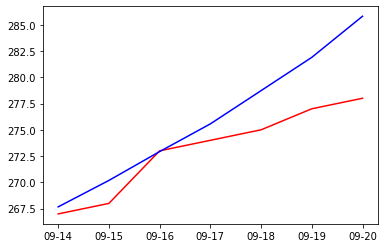

In [ ]:
print(submission.iloc[35:42,2])
print(submission_2.iloc[35:42,2])
Fort_Bend_prediction_week_2 = np.array(submission_2.iloc[35:42,2])
Fort_Bend_week_2 = np.array([267.,268.,273.,274.,275.,277,278.])
Harris_week_2 = np.array([])
fig, ax = plt.subplots()
index = ["09-14","09-15","09-16","09-17","09-18","09-19","09-20"]
plt.plot(index,Fort_Bend_week_2,color = 'r')
plt.plot(index,Fort_Bend_prediction_week_2,color = 'b')
plt.show()

Below I used the data of the next week to check if my predictions were performing well using the metric MSLE.

In [ ]:
"""#evaluation 
import math
from sklearn.metrics import mean_squared_log_error
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
actual = [2420.,2440.,2458.,2470.,2483.,46.,47.,47.,47.,47.,145.,147.,151.,152.,155.,155.,155.,155.,156.,157.,8.,8.,8.,8.,8.,267.,268.,273.,274.,275.,165.,165.,166.,167.,169.,9.,9.,9.,9.,9.]
def rmsle(y, y_pred):
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5
rmsles = []
j=0
k=5
l=0
z=5
for i in range(0,8):
  print(submission_2.values[l:z,2])
  print(actual[j:k])
  rmsles.append(mean_squared_log_error(actual[j:k],submission_2.values[l:z,2]))
  j=j+5
  k=k+5
  l= l+7
  z= z+7
print(rmsles)
print(mean_squared_log_error([46.,47.,47.,47.,47.,47.,47.5],[46.,46.,46.,46.,47.,47.,47.]))"""

[2422.50795 2435.92725 2448.85435 2463.469 2477.9739]
[2420.0, 2440.0, 2458.0, 2470.0, 2483.0]
[46.0 46.0 46.0 46.0 47.0]
[46.0, 47.0, 47.0, 47.0, 47.0]
[145.10944 146.31076 147.6109 149.19351 151.1802]
[145.0, 147.0, 151.0, 152.0, 155.0]
[154.87067 156.555228 157.650257 159.355868 160.793367]
[155.0, 155.0, 155.0, 156.0, 157.0]
[8.0012865 8.324205 8.627693 8.991761 9.381204]
[8.0, 8.0, 8.0, 8.0, 8.0]
[267.67062 270.18558 272.92804 275.56403 278.72568]
[267.0, 268.0, 273.0, 274.0, 275.0]
[165.00296 165.09131 169.01877 170.19328 172.41519]
[165.0, 165.0, 166.0, 167.0, 169.0]
[9.0 9.0 9.0 9.5 9.5]
[9.0, 9.0, 9.0, 9.0, 9.0]
[5.770327631053549e-06, 0.00026594762331082114, 0.0002976265244817743, 0.00027861443548993323, 0.007421899739409368, 5.6749556667786446e-05, 0.00021428240042084258, 0.0009521920478720393]
0.00020530363881402872


This is the end of my work for COVID-19 Houston Datathon. It was an interesting experience as I explored deeply the challenging problem of Time Series prediction. Specifically for Covid-19 it was great that I was able to contribute to the competition with my data analysis. For future work on this project I would definitely try to use external data to further improve my weekly predictions.I hope that you found it helpful.